# Predicting fish weight from other highly correlated covariates

## Report outline
- Introduction, analysis, results and references.
- Present dataset, including correlation matrix, discuss multicollinearities.
- Motivate one-hot-encodings for regression methods / bypass the need for group lasso

- Regression: predict weight, using OLS, ridge, lasso and group-lasso. Find best regularization parameters for ridge, lasso and group-lasso.
    Solved using best mean score from cross-validation.
- Discuss what method is best (OLS, Lasso, Ridge, Group-lasso).
- Discuss goodness-of-fit and uncertainty for the final chosen model.


### Todo notes
- max 3 pages.
- if time, colorize dots in seaborn pairplot per species.
- if time, look into jupyter contrib nbextensions for rendering Python variables in Markdown cells.
- change lambda->alpha everywhere




## Introduction

### The dataset - Fish Market
Our dataset contains 159 samples from 7 different species of fish [2]. With this dataset, our aim is to create a predictive model using multiple linear regression to estimate the weight of the fish. 

Below, the correlation matrix is shown for continuous variables. Looking at the correlation matrix, it is clear that the covariates suffer from multicollinearity. Notice that the covariates regarding the lengths of the fish are nearly perfectly correlated. 

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


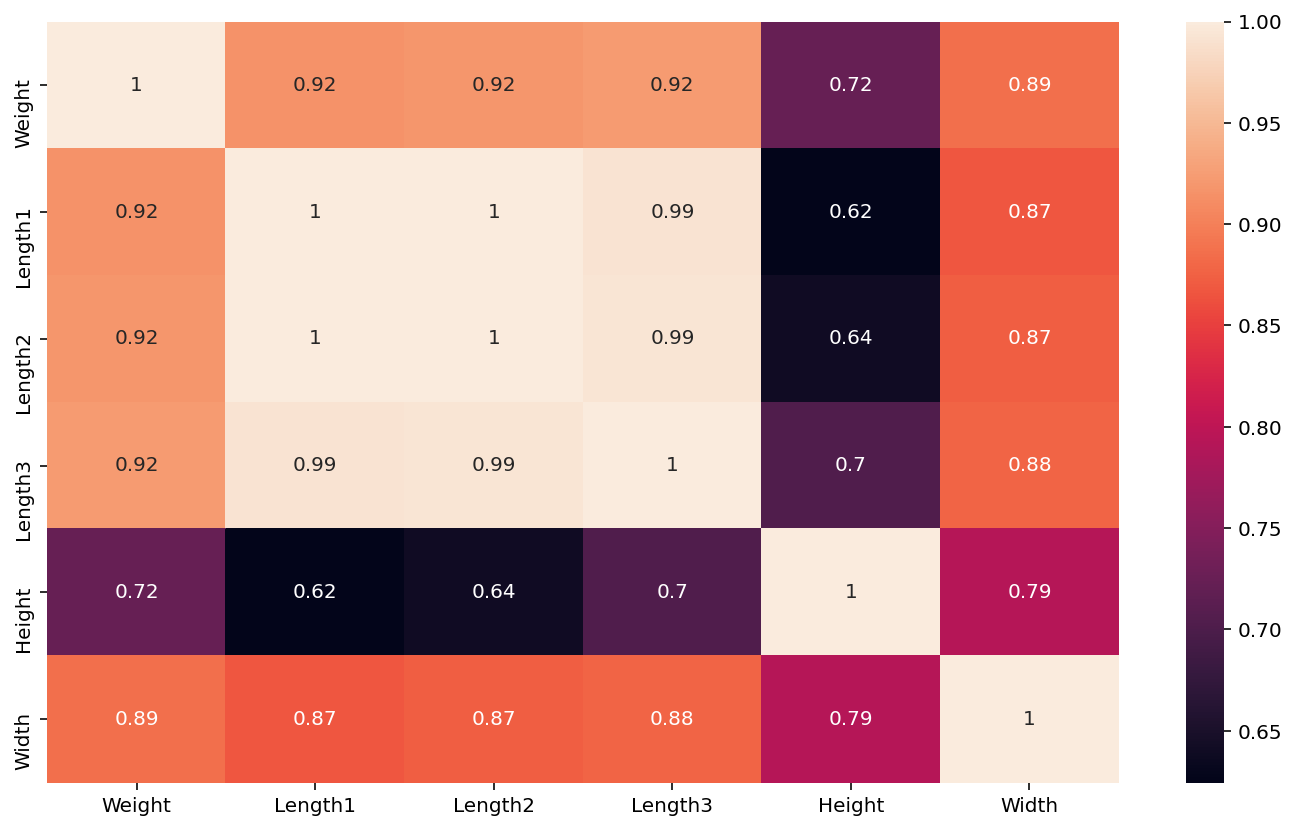

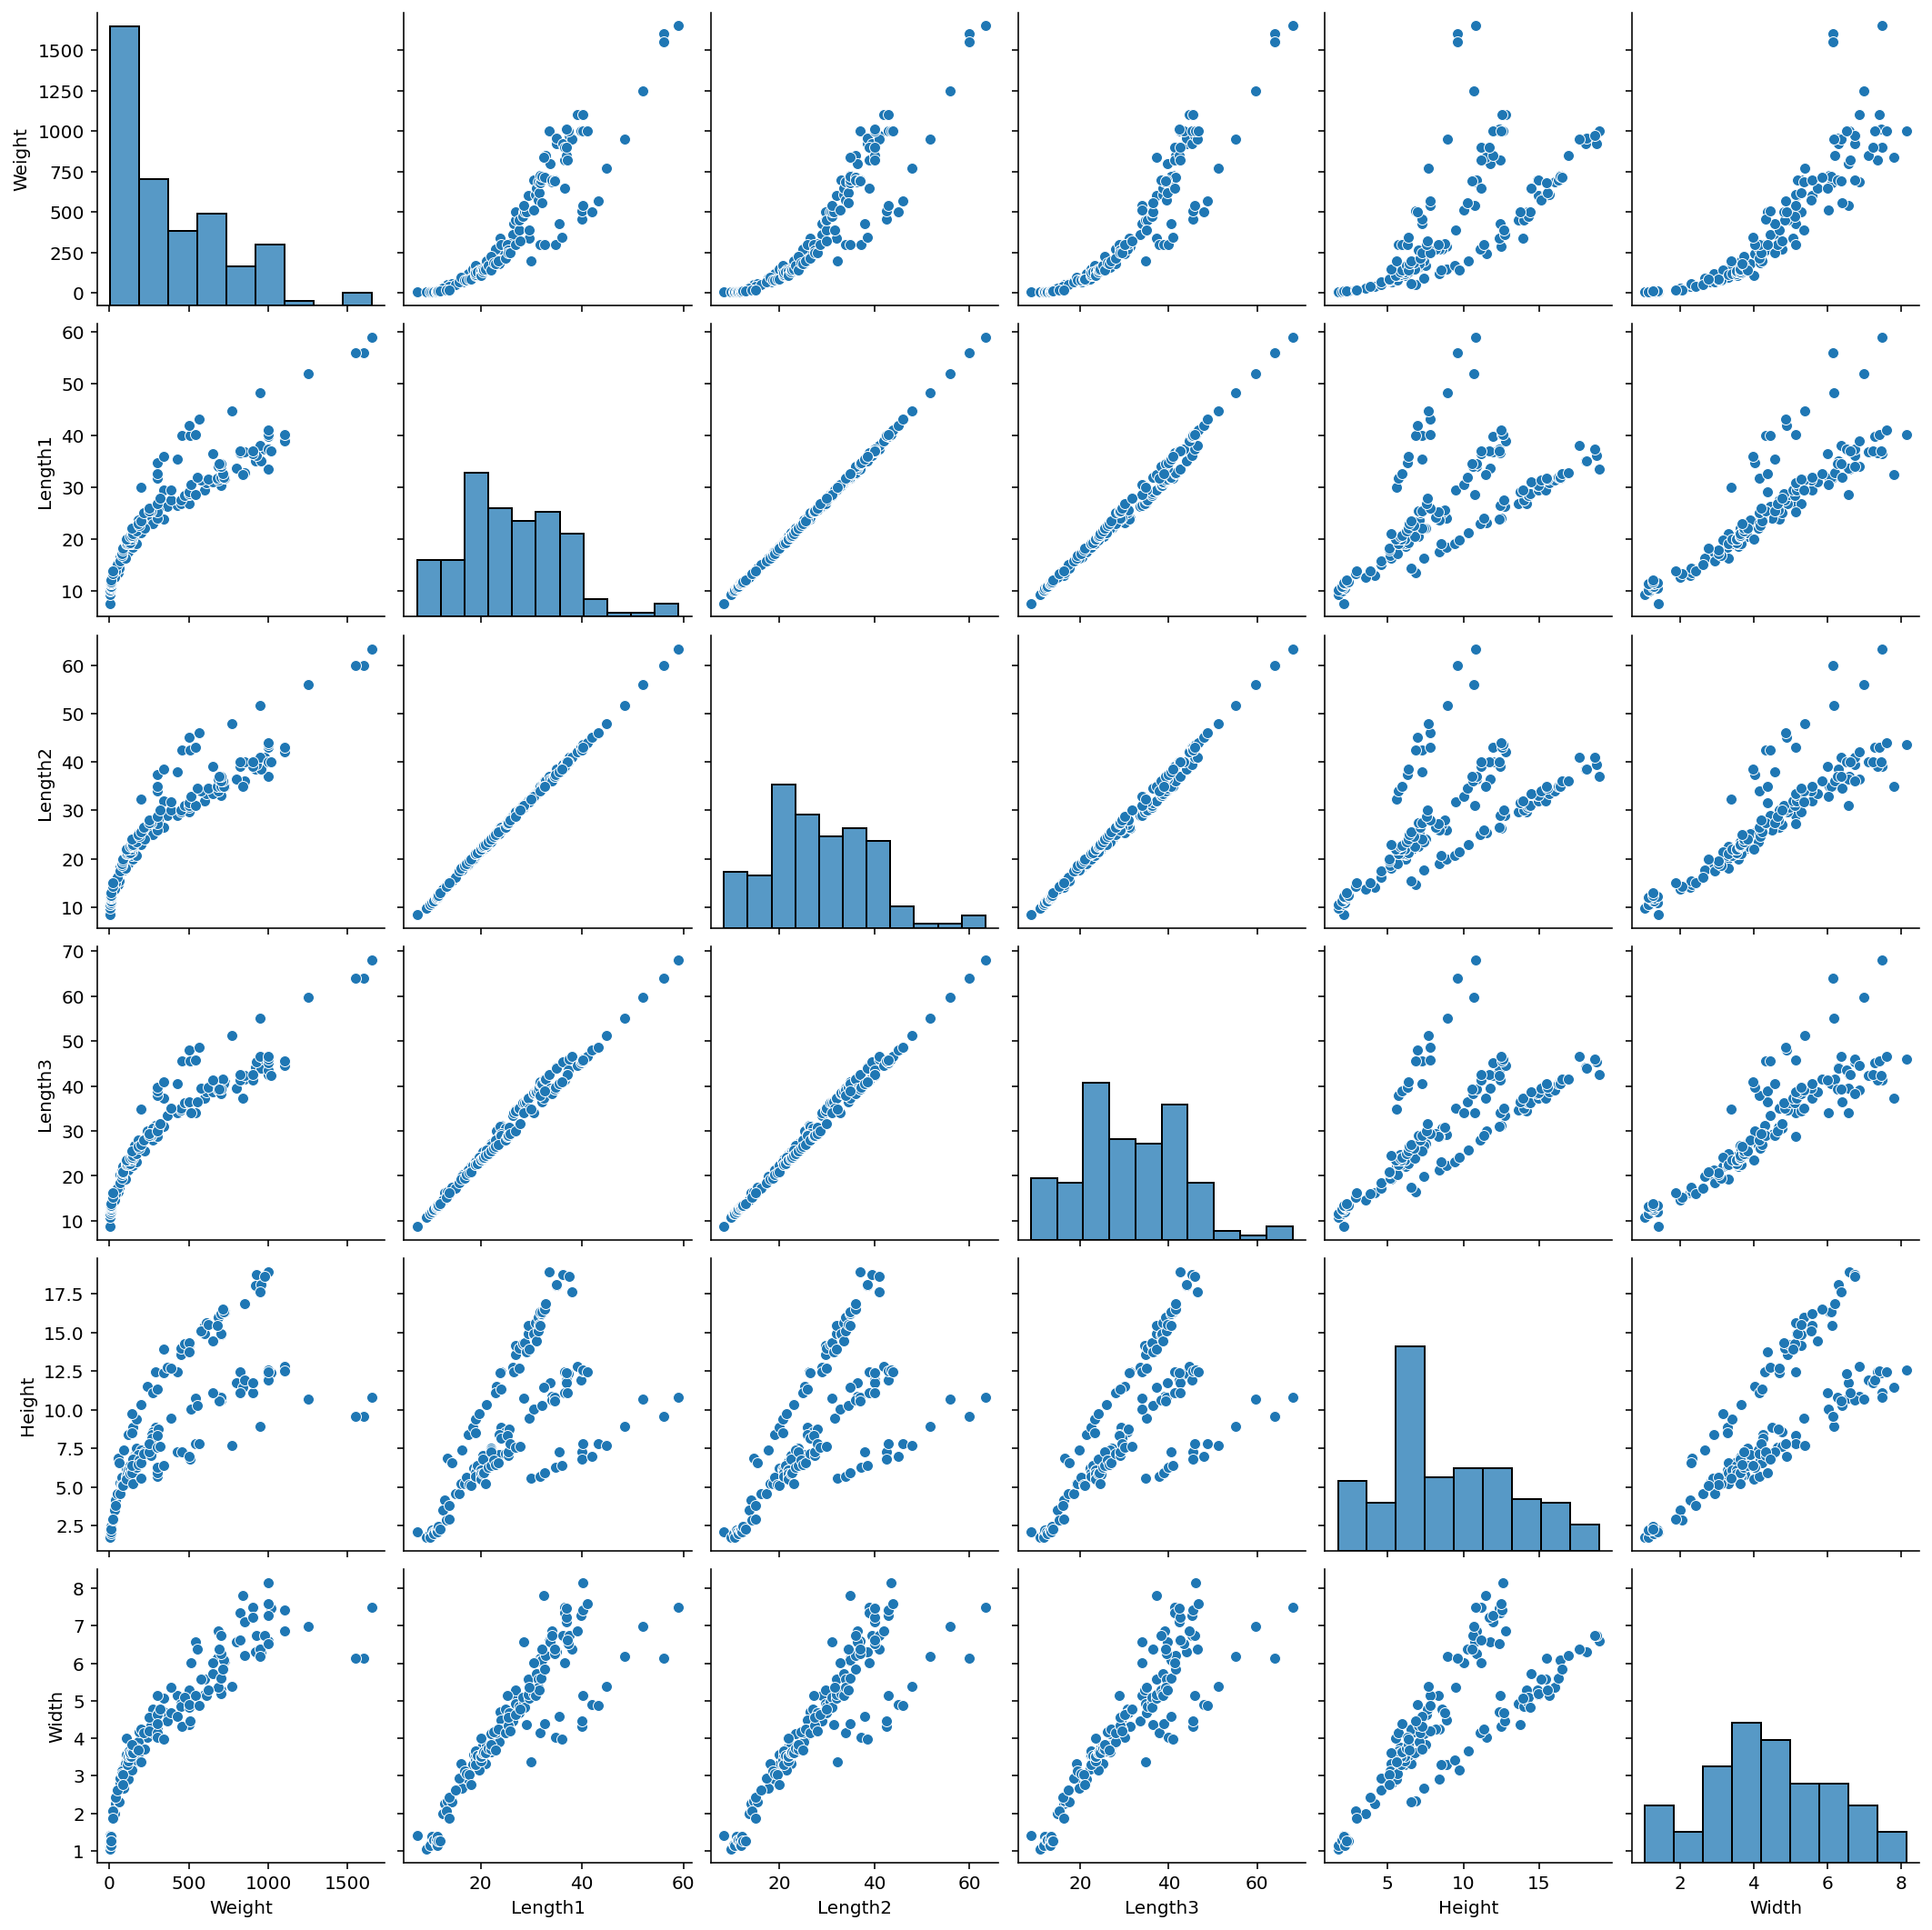

In [2]:
import pandas
import seaborn as sn
import matplotlib.pyplot as plt

# Load Fish Market dataset
data = pandas.read_csv("Fish.csv")

print(data.head())


# Removing outliers (there is one)
data = data[data.Weight != 0]

# Print correlation matrix and pair plot
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

sn.pairplot(data)
plt.show()

## Data preprocessing
To prepare the data, we separate the covariates, $X$, from the target values, $y$, from the full dataset. To accommodate the categorical variable $\textit{Species}$, we use one-hot encoding. This covariate is therefore split into 7 columns of boolean values. Then, the data is split into training and test sets. The normalization parameters are fit to the training data only, such that we avoid peeking at the test data in normalization.

The one-hot encoded $\textit{Species}$ are included in the new correlation matrices below. Naturally, the species seem to group the data into narrow ranges of the other physical attributes, i.e., $\textit{Species}$ may be an important predictor for the weight.

   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0              1               0              0             0              0   
1              1               0              0             0              0   
2              1               0              0             0              0   
3              1               0              0             0              0   
4              1               0              0             0              0   

   Species_Smelt  Species_Whitefish  Weight  Length1  Length2  Length3  \
0              0                  0   242.0     23.2     25.4     30.0   
1              0                  0   290.0     24.0     26.3     31.2   
2              0                  0   340.0     23.9     26.5     31.1   
3              0                  0   363.0     26.3     29.0     33.5   
4              0                  0   430.0     26.5     29.0     34.0   

    Height   Width  
0  11.5200  4.0200  
1  12.4800  4.3056  
2  12.3778 

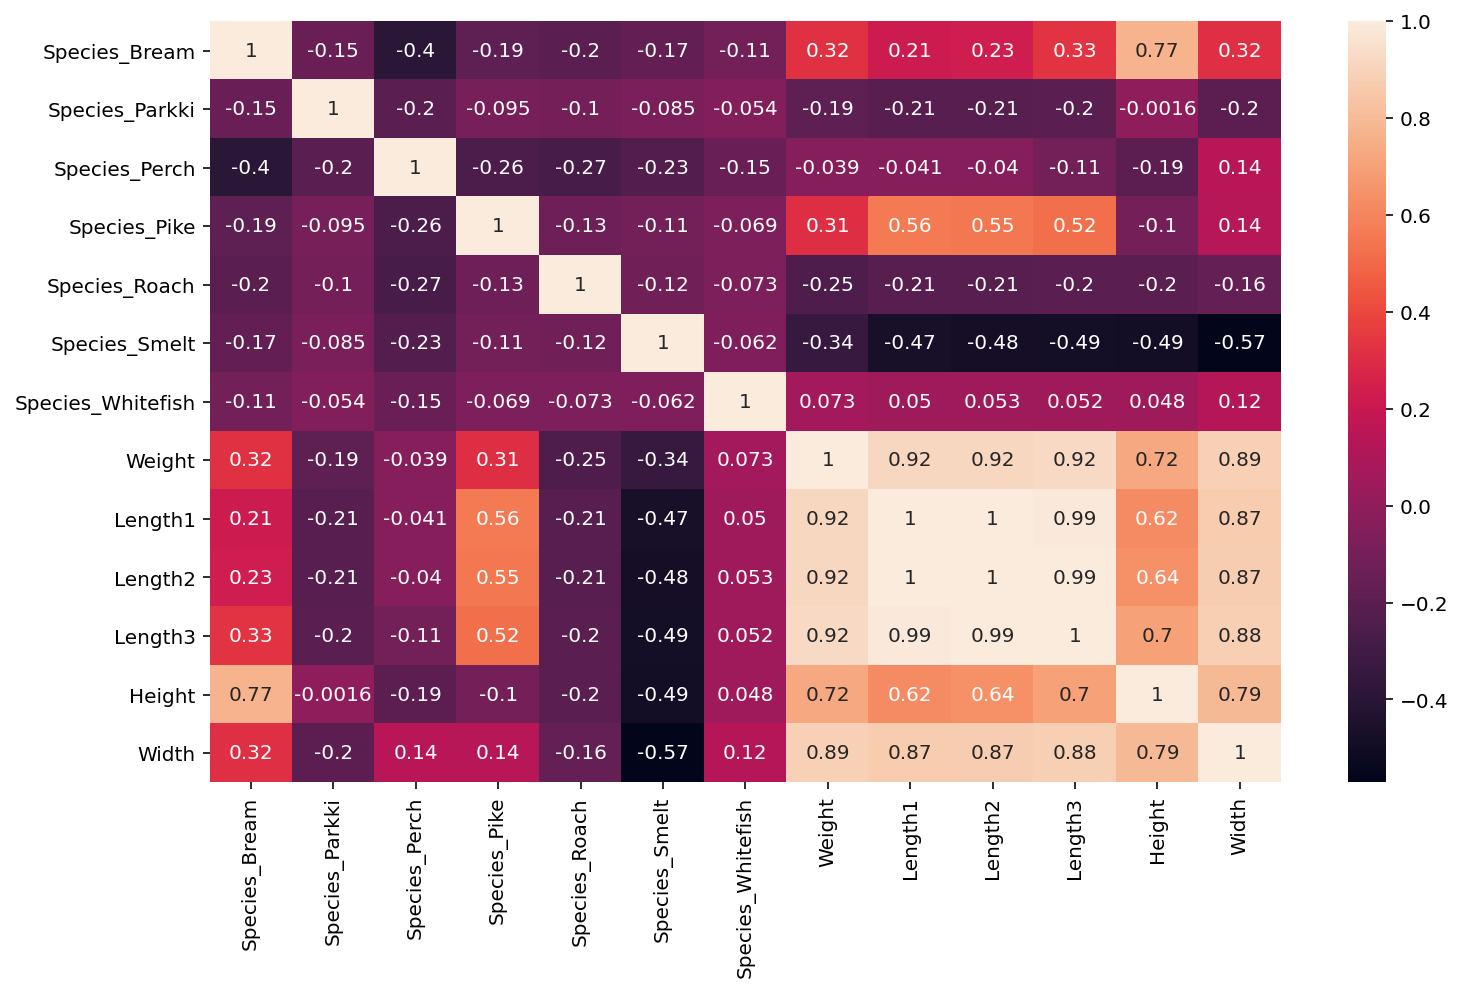

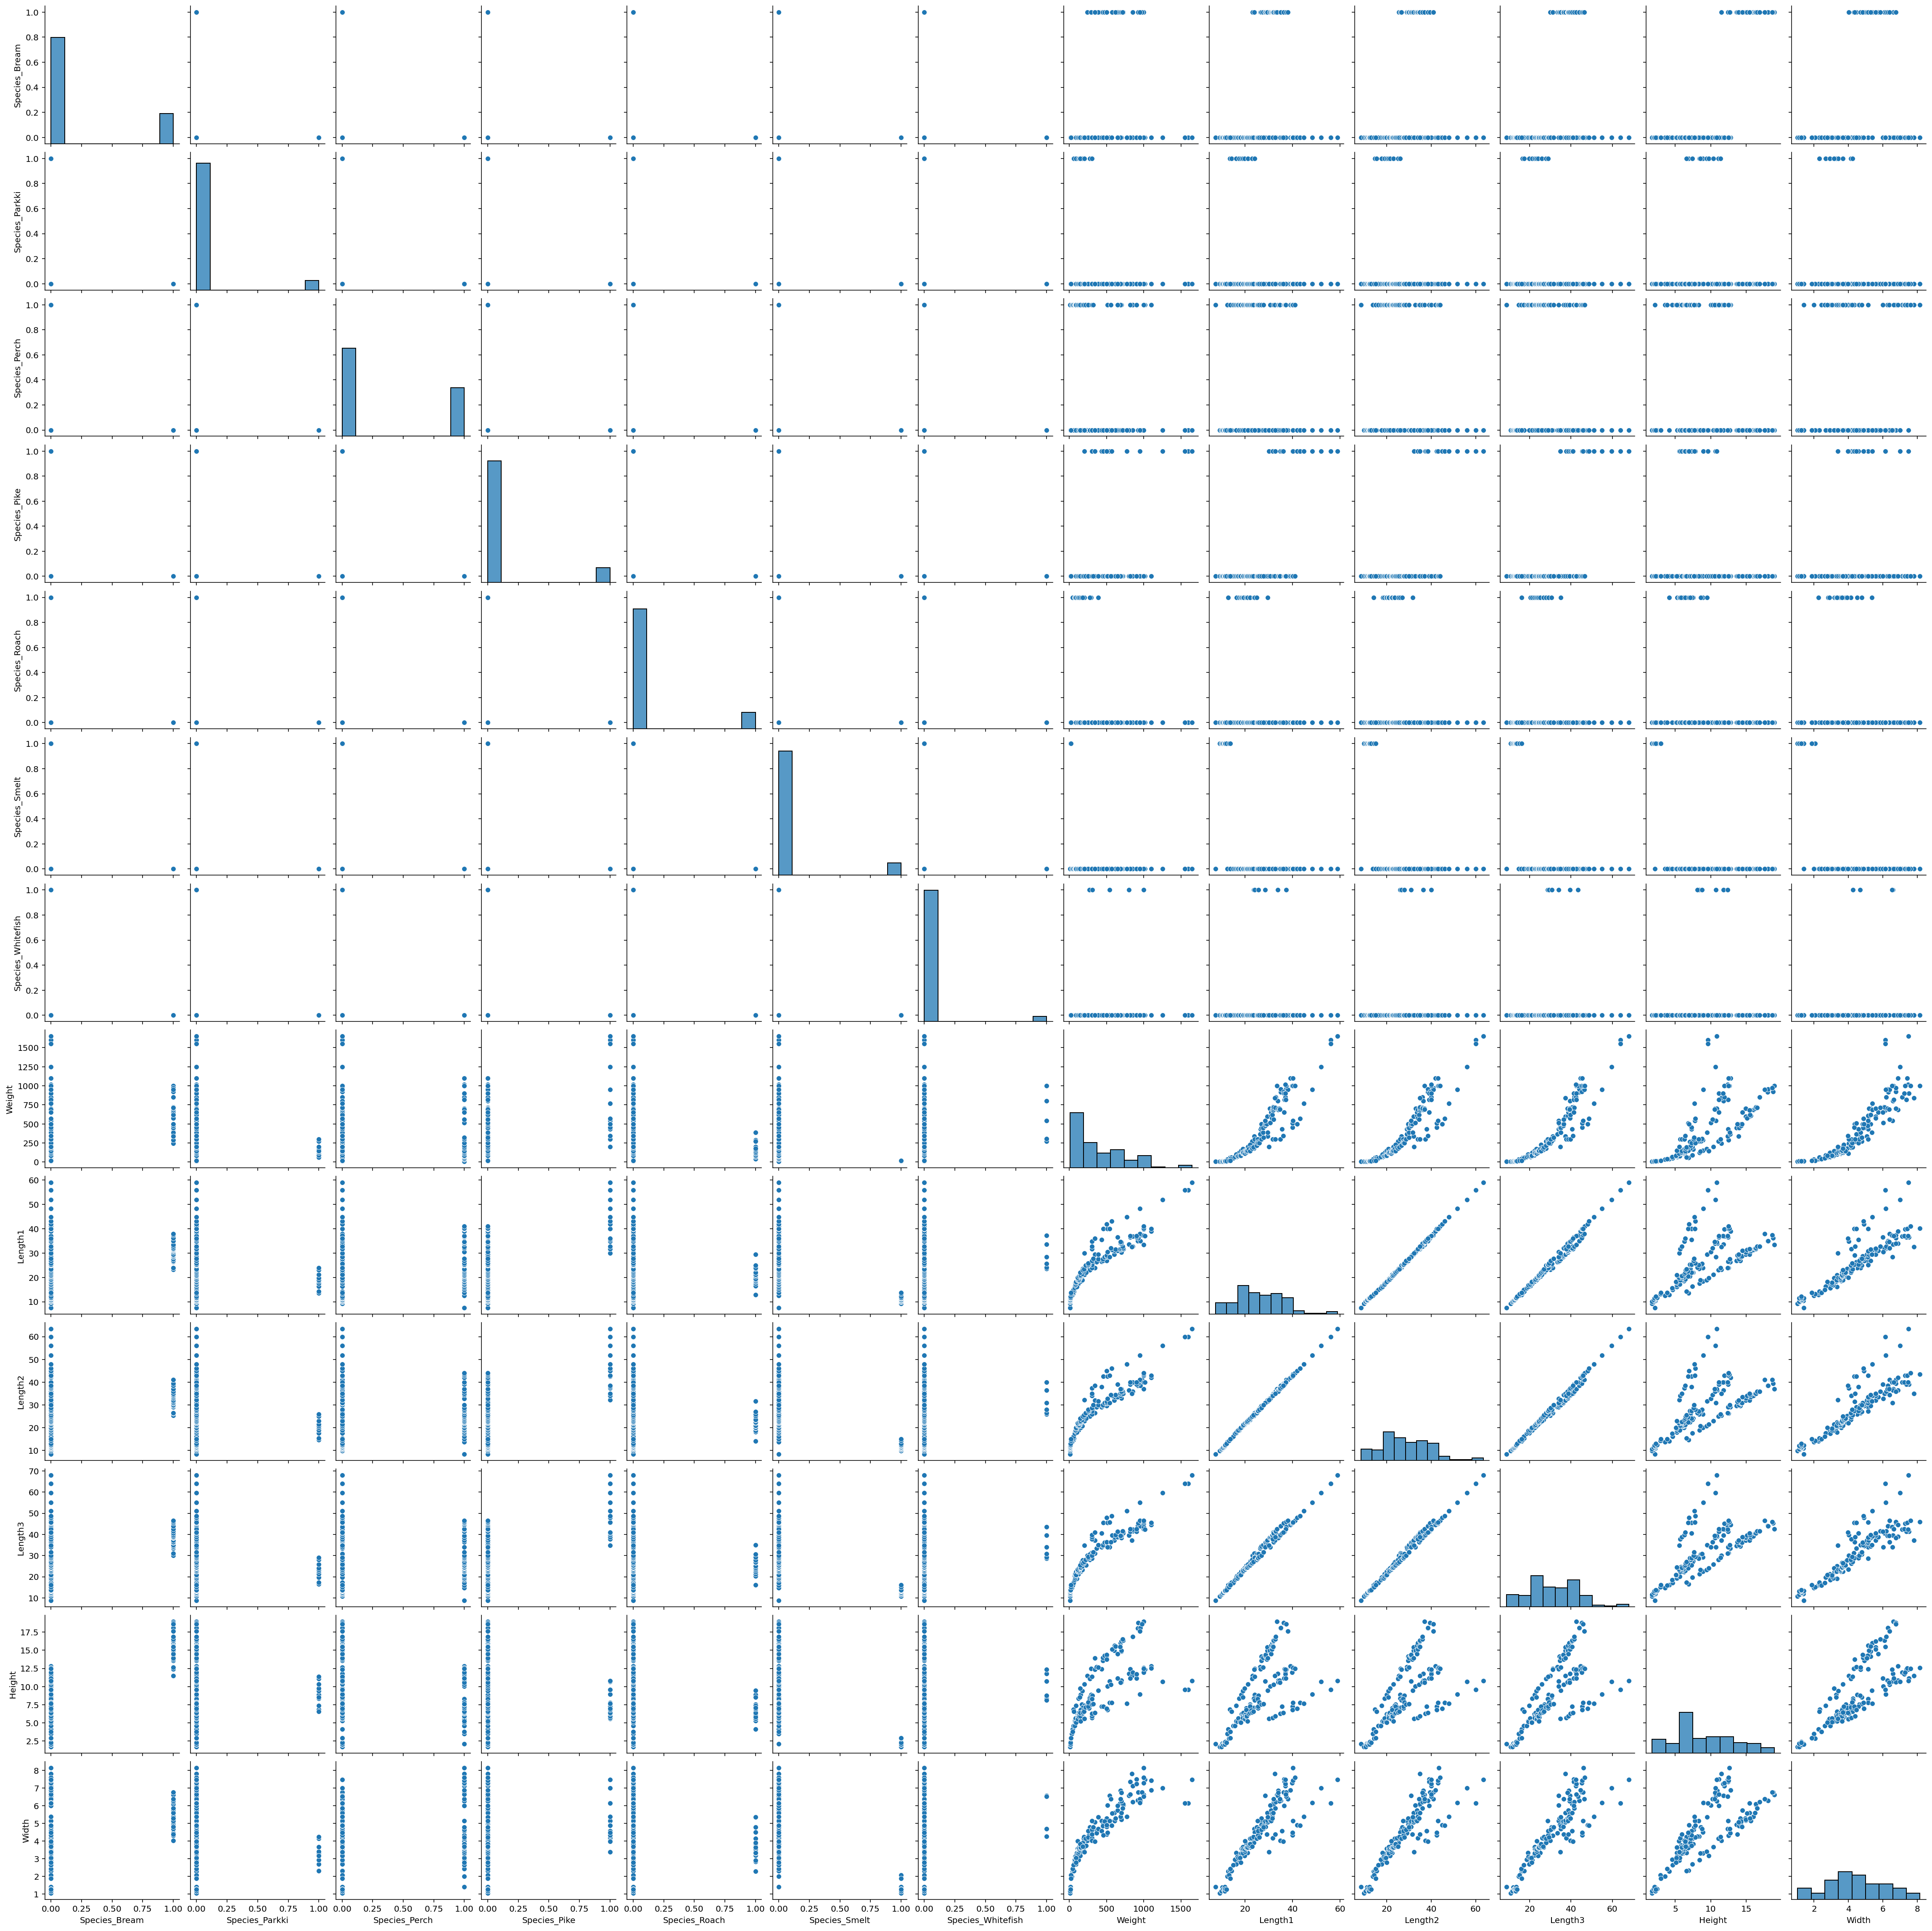

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# One-Hot encoding the species covariate
species = pandas.get_dummies(data.Species, prefix="Species")
X = data.copy().drop(["Species"], axis=1)
X = pandas.concat([species, X], axis=1)
print(X.head())

# Plot correlation with one-hot encoding
corrMatrix = X.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

sn.pairplot(X)
plt.show()

# Separating data into response values (Y) and inputs (X)
y = data["Weight"]
X = X.drop(["Weight"], axis=1)



# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)  # Unleash the random when all code is finished

# Normalize columns in X, fitting the normalization parameters to the training data only
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_train = pandas.DataFrame(X_train_scaled, columns=X.columns)

# Use normalization parameters found for the training data to transform the test data.
X_test_scaled = min_max_scaler.transform(X_test)
X_test = pandas.DataFrame(X_test_scaled, columns=X.columns)

# Normalize y
# y = ( y - min(y) ) / (max(y) - min(y))

# Analysis
In this section we apply Ordinary Least Squares, Ridge regression, Lasso regression and Group Lasso regression on our data. Each method will be briefly introduced and their results are compared in the next chapter.

---

## Least Squares
Ordinary least squares (OLS) will be used as a benchmark against the regularized methods. In short, OLS constructs an estimator $\hat{\beta}$ by:

$\hat{y} = X^T\hat{\beta}$, where $\hat{\beta}$ is chosen such that $\min_\hat{\beta} ||X^T\hat{\beta} - y||_2^2$.

To find $\hat{\beta}$, we use the implementation in sklearn.linear_model.LinearRegression(), and apply 10-fold cross-validation using sklearn.model_selection.cross_validate() to evaluate the model. 

In [62]:
from sklearn import linear_model as lm
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

method = lm.LinearRegression()

scores = cross_validate(method, X_train, y_train, cv=10, scoring="r2")
print("Cross-Validation R2-score is {:0.3f} +/- {:0.3f}".format(scores["test_score"].mean(), scores["test_score"].std()))
ols_cv_mean = scores["test_score"].mean()
ols_cv_std = scores["test_score"].std()


LS_model = method.fit(X_train,y_train)

Cross-Validation R2-score is 0.908 +/- 0.048


## Functions for cross-validating a range of regularizer values.
In the regularized methods, some hyperparameter tuning is required to determine the optimal level of regularization. Therefore, we need to create some functions that cross-validate a range of hyperparameters.

We define a cross-validation function to find the mean and standard deviation for the R2-scores of a range of the regularization hyperparameter. This function also returns the coefficients of the model.

To illustrate the best choice for the regularizer, we also define a function to plot the cross-validated scores vs. the regularization hyperparameter, and a function to plot the model coefficients vs the regularization hyperparameter.

In [5]:
# Cross-Validation for regularization selection
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

# Create custom color map to avoid cycling through standard colors
rcParams['axes.prop_cycle'] = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'navy', 'maroon'])

def reg_select(method_func, X, y, alphas=[0.1,1,10]):
    # Takes a method (e.g., ridge, lasso) and performs cross validation on each value for the 
    score_means = []
    score_stds = []
    score_coef = []
    
    # Do cross-validation for each value for alpha.
    for alpha in alphas:
        # Progress bar
        print("\rProcessing alpha {:0.2f} of {:0.2f}".format(alpha, alphas[-1]), end="", flush=True)
        
        # Update method's regularizer value
        method = method_func(alpha=alpha, max_iter=20000000, tol=0.0001)

        # more k-fold CV:
        scores = cross_validate(method, X, y, cv=10, return_estimator=True, scoring='r2')
        
        # Store scores
        score_means.append(scores["test_score"].mean())
        score_stds.append(scores["test_score"].std())
        score_coef.append(method.fit(X, y).coef_)
       
    score_means = np.array(score_means)
    score_stds  = np.array(score_stds)
    score_coef  = np.array(score_coef)
    
    print(" ")  # Newline after progress bar has finished
    return score_means, score_stds, score_coef


def plot_regularizer(range_reg, mean_scores, std_scores, coeffs, column_name, method="Ridge"):
    plt.figure()
    plt.plot(range_reg, mean_scores, 'r+')
    best_alpha = range_reg[np.argmax(mean_scores)]
    plt.axvline(best_alpha)
    plt.fill_between(range_reg, (mean_scores - std_scores), (mean_scores + std_scores), alpha=0.1)
    plt.xscale('log')
    plt.xlabel(r"$\log (\alpha)$")
    plt.ylabel("R2 score")
    plt.title(method+" scores as a function of the regularization hyperparameter", fontsize=20);
    
    plt.figure()
    plt.plot(range_reg, coeffs)
    plt.title(method+" coefficients as a function of the regularization hyperparameter", fontsize=20);
    plt.xscale('log')
    plt.xlabel(r"$\log (\alpha)$")
    plt.ylabel("Weights")
    plt.legend(column_name)

## Ridge regression

Regularizes the models by limiting the coefficients' size according to: 
$\min_\beta ||X^T\beta - y||_2^2 + \alpha ||\beta||_2^2$

We first find the mean and standard deviations of the R2 scores according to the function defined above. We then select the regularization hyperparameter that gave the best mean score during the cross-validation.

The first plot shows the R2 scores as a function of the regularization hyperparameter, where the blue vertical line shows the $\alpha$ that gave the best mean R2-score. The second plot shows how the coefficients change with increasing $\alpha$.

In the coefficient plot, we can see that the coefficient for the almost perfectly correlated variables length1 and length2 are poorly defined. Length2 has a large positive value and the coefficient of length1 cancels this out by having a corresponding large negative value. As the regularization hyperparameter is increased, these coefficients become smaller, and the problem is alleviated as described in [1, p. 63].

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.03 of 10000.00

Processing alpha 0.04 of 10000.00

Processing alpha 0.04 of 10000.00

Processing alpha 0.05 of 10000.00

Processing alpha 0.07 of 10000.00

Processing alpha 0.08 of 10000.00

Processing alpha 0.10 of 10000.00

Processing alpha 0.12 of 10000.00

Processing alpha 0.15 of 10000.00

Processing alpha 0.19 of 10000.00

Processing alpha 0.23 of 10000.00

Processing alpha 0.28 of 10000.00

Processing alpha 0.35 of 10000.00

Processing alpha 0.43 of 10000.00

Processing alpha 0.53 of 10000.00

Processing alpha 0.66 of 10000.00

Processing alpha 0.81 of 10000.00

Processing alpha 1.00 of 10000.00

Processing alpha 1.23 of 10000.00

Processing alpha 1.52 of 10000.00

Processing alpha 1.87 of 10000.00

Processing alpha 2.31 of 10000.00

Processing alpha 2.85 of 10000.00

Processing alpha 3.51 of 10000.00

Processing alpha 4.33 of 10000.00

Processing alpha 5.34 of 10000.00

Processing alpha 6.58 of 10000.00

Processing alpha 8.11 of 10000.00

Processing alpha 10.00 of 10000.00

Processing alpha 12.33 of 10000.00

Processing alpha 15.20 of 10000.00

Processing alpha 18.74 of 10000.00

Processing alpha 23.10 of 10000.00

Processing alpha 28.48 of 10000.00

Processing alpha 35.11 of 10000.00

Processing alpha 43.29 of 10000.00

Processing alpha 53.37 of 10000.00

Processing alpha 65.79 of 10000.00

Processing alpha 81.11 of 10000.00

Processing alpha 100.00 of 10000.00

Processing alpha 123.28 of 10000.00

Processing alpha 151.99 of 10000.00

Processing alpha 187.38 of 10000.00

Processing alpha 231.01 of 10000.00

Processing alpha 284.80 of 10000.00

Processing alpha 351.12 of 10000.00

Processing alpha 432.88 of 10000.00

Processing alpha 533.67 of 10000.00

Processing alpha 657.93 of 10000.00

Processing alpha 811.13 of 10000.00

Processing alpha 1000.00 of 10000.00

Processing alpha 1232.85 of 10000.00

Processing alpha 1519.91 of 10000.00

Processing alpha 1873.82 of 10000.00

Processing alpha 2310.13 of 10000.00

Processing alpha 2848.04 of 10000.00

Processing alpha 3511.19 of 10000.00

Processing alpha 4328.76 of 10000.00

Processing alpha 5336.70 of 10000.00

Processing alpha 6579.33 of 10000.00

Processing alpha 8111.31 of 10000.00

Processing alpha 10000.00 of 10000.00

Best alpha is  0.1873817422860383
Score is 0.915 +/- 0.037


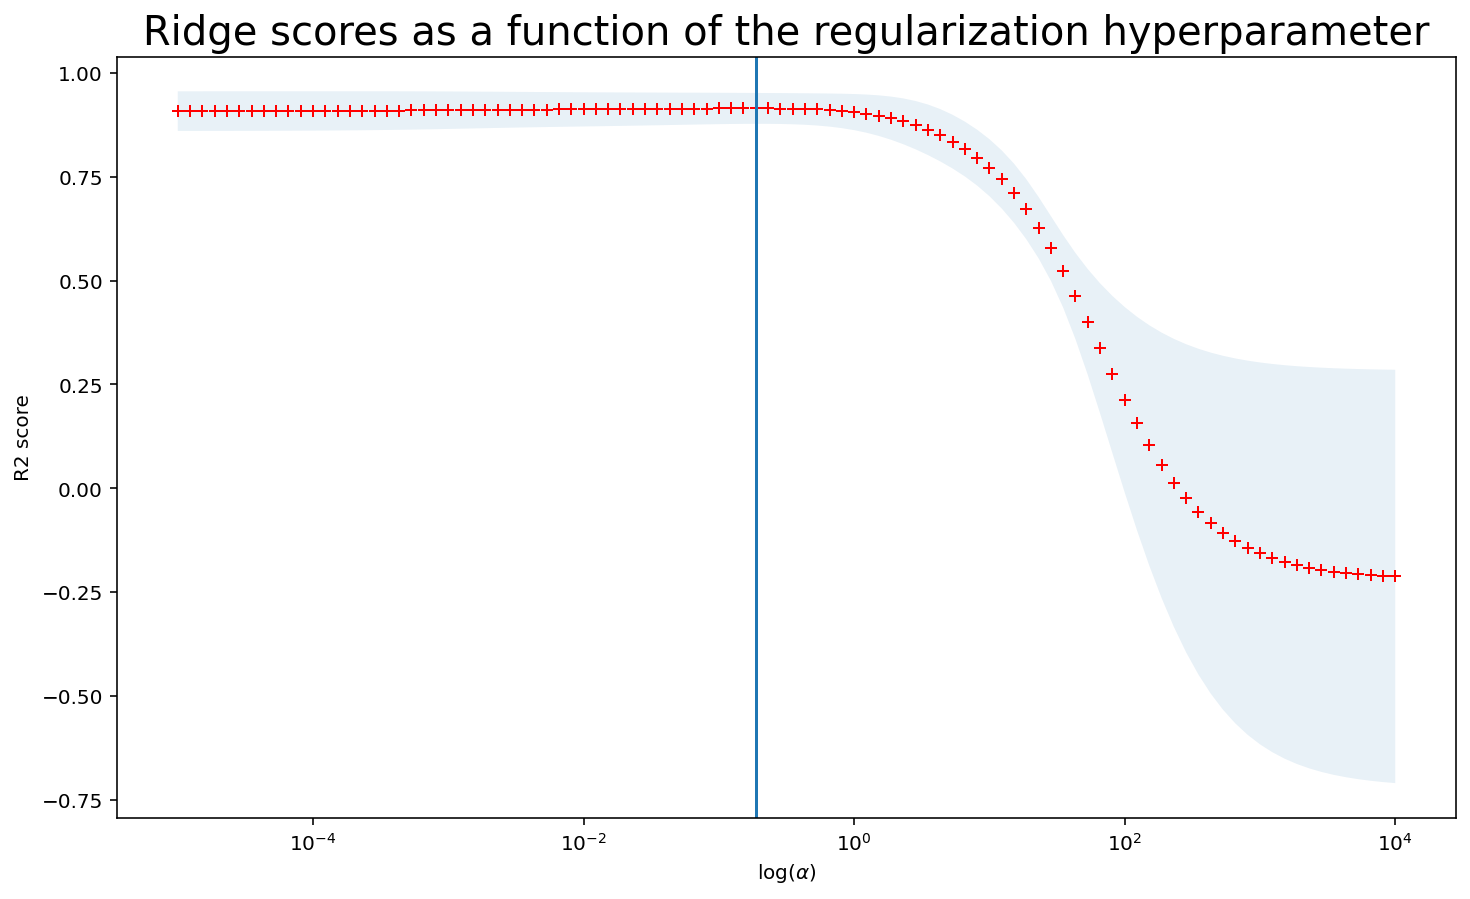

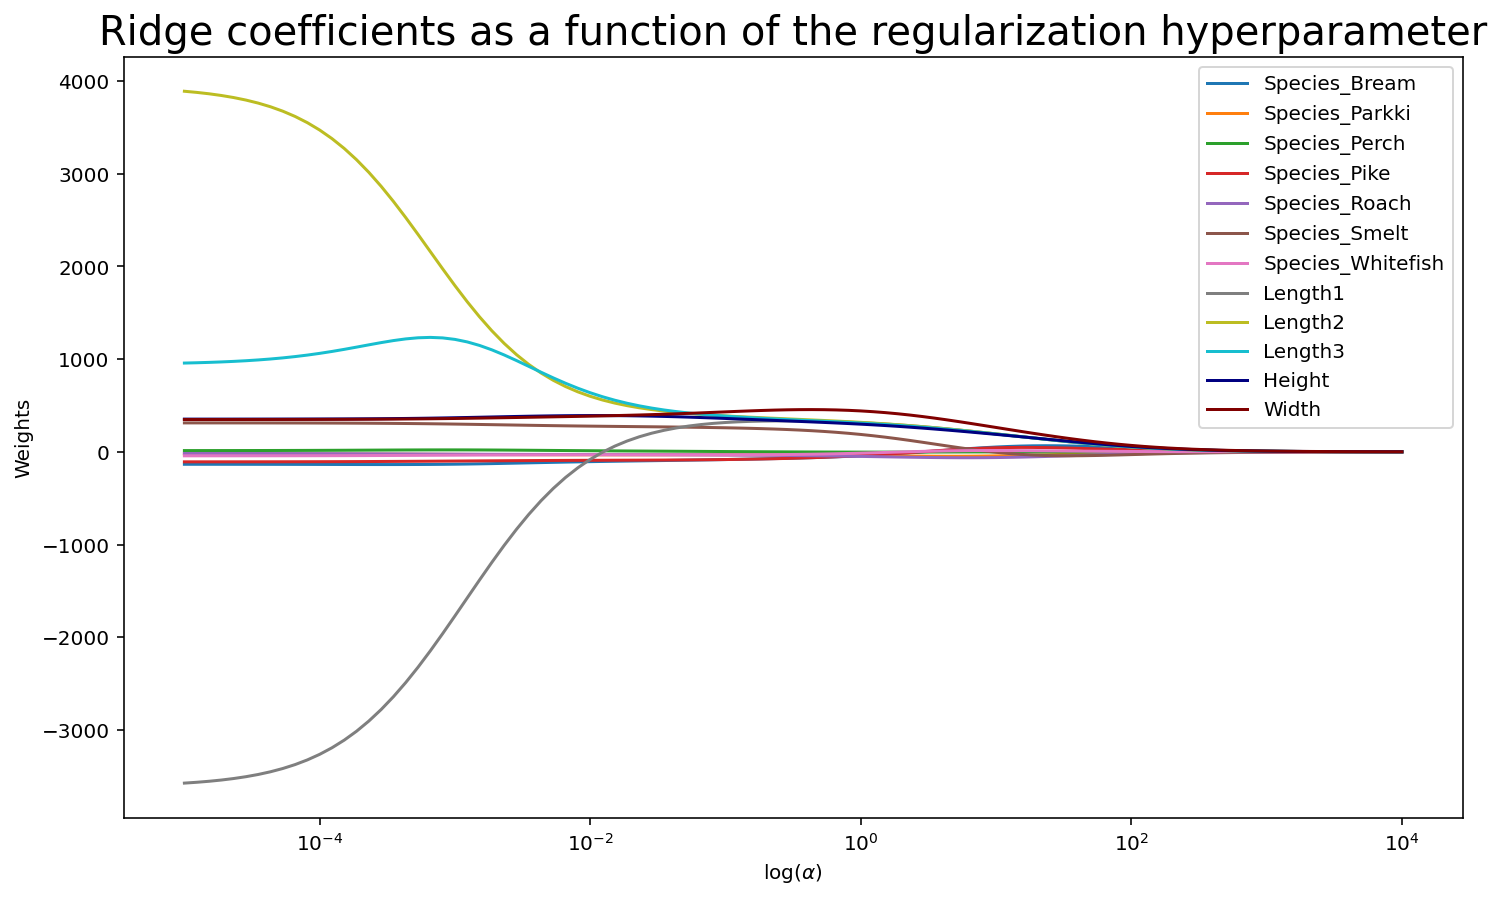

In [6]:
#Choose a range of interest for the penalty hyperparameter, where all coefficients are zero in one end and all coefficients are non-zero in the other end.
alphas = np.logspace(-5, 4, 100)
method = lm.Ridge

# Get mean/std and coeffs for Ridge regression method
ridge_means, ridge_stds, coeffs = reg_select(method, X_train, y_train, alphas)

# Plot them
plot_regularizer(alphas, ridge_means, ridge_stds, coeffs, list(X_train.columns), method="Ridge")

alpha_best = alphas[np.argmax(ridge_means)]
best_mean = ridge_means[np.argmax(ridge_means)]
best_std = ridge_stds[np.argmax(ridge_means)]
print("Best alpha is ", alpha_best)
print("Cross-Validation R2-score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

ridge_cv_mean = best_mean
ridge_cv_std = best_std

# Fit model with the optimal regularizer
Ridge_model = lm.Ridge(alpha=alpha_best).fit(X_train, y_train)

## Lasso

Regularizes the models by limiting the coefficients' size according to: $\min_\beta \frac{1}{2n_{samples}}||X^T\beta - y||_2^2 + \alpha ||\beta||_1$

The same procedure as done when finding the best hyperparameters for Ridge regression is followed below.
There is a similar interaction between the coefficents for $\textit{Length1}$ and $\textit{Length2}$ as for Ridge regression, but their development as the regularization increases is considerably less smooth than for Ridge.

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.00 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.01 of 1000.00

Processing alpha 0.02 of 1000.00

Processing alpha 0.02 of 1000.00

Processing alpha 0.02 of 1000.00

Processing alpha 0.03 of 1000.00

Processing alpha 0.03 of 1000.00

Processing alpha 0.04 of 1000.00

Processing alpha 0.04 of 1000.00

Processing alpha 0.05 of 1000.00

Processing alpha 0.06 of 1000.00

Processing alpha 0.07 of 1000.00

Processing alpha 0.08 of 1000.00

Processing alpha 0.09 of 1000.00

Processing alpha 0.11 of 1000.00

Processing alpha 0.13 of 1000.00

Processing alpha 0.15 of 1000.00

Processing alpha 0.18 of 1000.00

Processing alpha 0.21 of 1000.00

Processing alpha 0.25 of 1000.00

Processing alpha 0.29 of 1000.00

Processing alpha 0.34 of 1000.00

Processing alpha 0.40 of 1000.00

Processing alpha 0.48 of 1000.00

Processing alpha 0.56 of 1000.00

Processing alpha 0.66 of 1000.00

Processing alpha 0.77 of 1000.00

Processing alpha 0.91 of 1000.00

Processing alpha 1.07 of 1000.00

Processing alpha 1.26 of 1000.00

Processing alpha 1.48 of 1000.00

Processing alpha 1.75 of 1000.00

Processing alpha 2.06 of 1000.00

Processing alpha 2.42 of 1000.00

Processing alpha 2.85 of 1000.00

Processing alpha 3.35 of 1000.00

Processing alpha 3.94 of 1000.00

Processing alpha 4.64 of 1000.00

Processing alpha 5.46 of 1000.00

Processing alpha 6.43 of 1000.00

Processing alpha 7.56 of 1000.00

Processing alpha 8.90 of 1000.00

Processing alpha 10.48 of 1000.00

Processing alpha 12.33 of 1000.00

Processing alpha 14.51 of 1000.00

Processing alpha 17.07 of 1000.00

Processing alpha 20.09 of 1000.00

Processing alpha 23.64 of 1000.00

Processing alpha 27.83 of 1000.00

Processing alpha 32.75 of 1000.00

Processing alpha 38.54 of 1000.00

Processing alpha 45.35 of 1000.00

Processing alpha 53.37 of 1000.00

Processing alpha 62.80 of 1000.00

Processing alpha 73.91 of 1000.00

Processing alpha 86.97 of 1000.00

Processing alpha 102.35 of 1000.00

Processing alpha 120.45 of 1000.00

Processing alpha 141.75 of 1000.00

Processing alpha 166.81 of 1000.00

Processing alpha 196.30 of 1000.00

Processing alpha 231.01 of 1000.00

Processing alpha 271.86 of 1000.00

Processing alpha 319.93 of 1000.00

Processing alpha 376.49 of 1000.00

Processing alpha 443.06 of 1000.00

Processing alpha 521.40 of 1000.00

Processing alpha 613.59 of 1000.00

Processing alpha 722.08 of 1000.00

Processing alpha 849.75 of 1000.00

Processing alpha 1000.00 of 1000.00

Best alpha is 

 0.6579332246575675
Score is 0.914 +/- 0.039


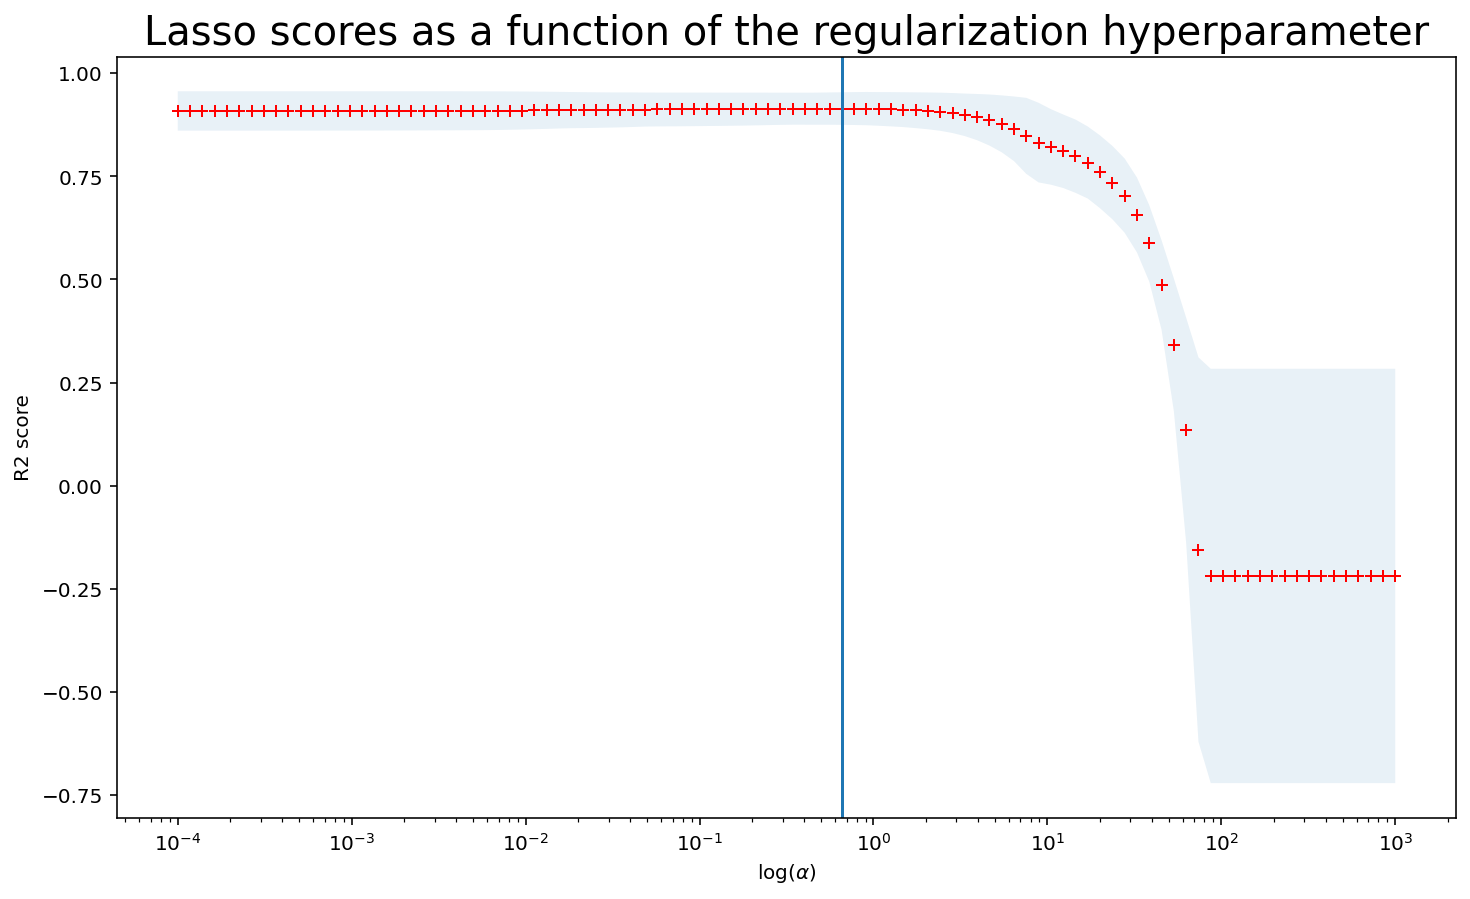

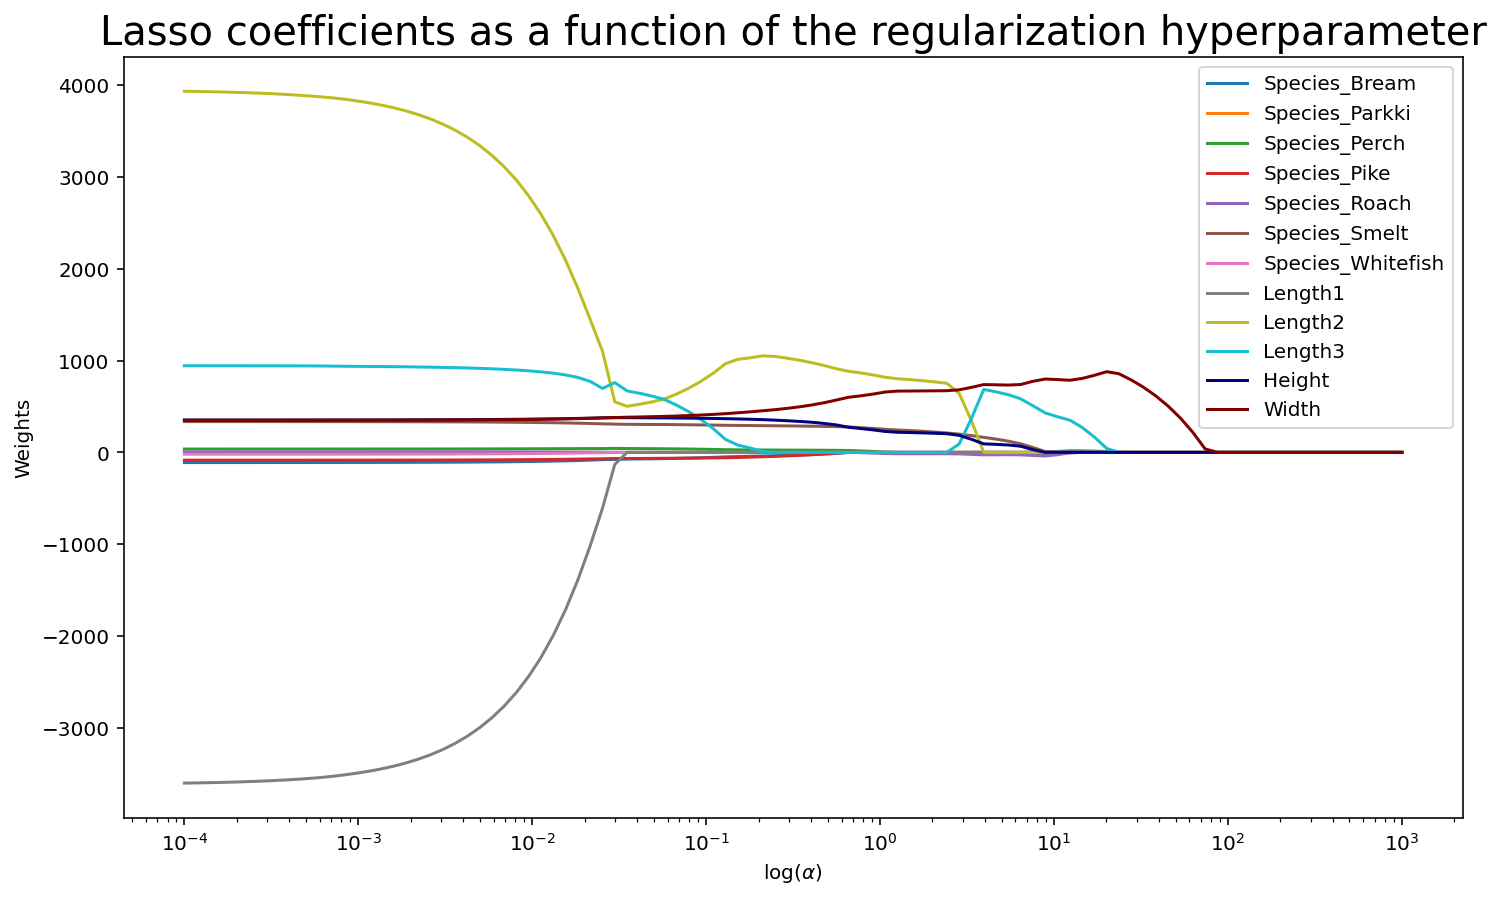

In [11]:
#Choose a range of interest for the penalty hyperparameter, where all coefficients are zero in one end and all coefficients are not zero in the other end.
alphas = np.logspace(-4, 3, 100)
method = lm.Lasso

# Get mean/std and coeffs for Lasso regression method
lasso_means, lasso_stds, lasso_coeffs = reg_select(method, X_train, y_train, alphas)

# Plot them
plot_regularizer(alphas, lasso_means, lasso_stds, lasso_coeffs, list(X_train.columns), method="Lasso")


# lambda max når alle coeffs blir 0
alpha_best = alphas[np.argmax(lasso_means)]
best_mean = lasso_means[np.argmax(lasso_means)]
best_std = lasso_stds[np.argmax(lasso_means)]
print("Best alpha is ", alpha_best)
print("Score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

lasso_cv_mean = best_mean
lasso_cv_std = best_std

# Fit model with the optimal regularizer
Lasso_model = lm.Lasso(alpha=alpha_best).fit(X_train,y_train)


## Sparse Group Lasso


The Sparse Group Lasso estimator is defined by:

$\argmin_{\beta_g \in \mathbb{R}^{d_g}} || \sum_{g\in \mathcal{G}} [\mathbf{X}_g \beta_g]-\mathbf{y}||_2^2 + \lambda_1 ||\beta||_1 + \lambda_2 \sum_{g\in\mathcal{G}}\sqrt{d_g}||\beta_g||_2$ [3]

The sparse group lasso regularizer is a combination of standard lasso and group lasso regularization. This also means that there are two hyperparameters to tune.

The first hyperparameter is group regularization, denoted in code by "group_reg" and the second hyperparameter is $L_1$ regularization, denoted by "l1_reg". Therefore, we need 2D cross-validation to determine best set of hyperparameters. 

We plot mean cross-validated R2 score on a surface to determine best set of hyperparameters, the best set is indicated by a red dot.

In [67]:
# Experimental Group lasso
from group_lasso import GroupLasso

# 2D Cross-Validation for Group Lasso
l1_reg_space = np.logspace(-4, 1, 25)
group_reg_space = np.logspace(-4, 1, 25)
gl_scores = np.empty((25,25))
gl_std = np.empty((25,25))

groups = [0,0,0,0,0,0,0,1,1,1,2,3]  # With one-hot encoding, grouping species and lengths
#groups = [0,0,0,1,2,3]  # Without species covariate, 

for i, l1_reg in enumerate(l1_reg_space):
    for j, group_reg in enumerate(group_reg_space):
        print("\rProcessing [{},{}]:".format(i,j), end="", flush=True)
        gl = GroupLasso(
            groups=groups,
            group_reg=group_reg,
            l1_reg=l1_reg,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=10000,
            tol=1e-3,
        )
        #scores[i,j] = cross_validate(method, X_no_species_train, y_no_species_train, cv=10, scoring="r2")
        temp_scores = cross_validate(gl, X_train, y_train, cv=10, scoring="r2")["test_score"]
        gl_scores[i,j] = temp_scores.mean()
        gl_std[i,j] = temp_scores.std()


#group_model = gl.fit(X_train, y_train)

#group_model.score(X_test, y_test)

Processing [0,0]:

Processing [0,1]:

Processing [0,2]:

Processing [0,3]:

Processing [0,4]:

Processing [0,5]:

Processing [0,6]:

Processing [0,7]:

Processing [0,8]:

Processing [0,9]:

Processing [0,10]:

Processing [0,11]:

Processing [0,12]:

Processing [0,13]:

Processing [0,14]:

Processing [0,15]:

Processing [0,16]:

Processing [0,17]:

Processing [0,18]:

Processing [0,19]:

Processing [0,20]:

Processing [0,21]:

Processing [0,22]:

Processing [0,23]:

Processing [0,24]:

Processing [1,0]:

Processing [1,1]:

Processing [1,2]:

Processing [1,3]:

Processing [1,4]:

Processing [1,5]:

Processing [1,6]:

Processing [1,7]:

Processing [1,8]:

Processing [1,9]:

Processing [1,10]:

Processing [1,11]:

Processing [1,12]:

Processing [1,13]:

Processing [1,14]:

Processing [1,15]:

Processing [1,16]:

Processing [1,17]:

Processing [1,18]:

Processing [1,19]:

Processing [1,20]:

Processing [1,21]:

Processing [1,22]:

Processing [1,23]:

Processing [1,24]:

Processing [2,0]:

Processing [2,1]:

Processing [2,2]:

Processing [2,3]:

Processing [2,4]:

Processing [2,5]:

Processing [2,6]:

Processing [2,7]:

Processing [2,8]:

Processing [2,9]:

Processing [2,10]:

Processing [2,11]:

Processing [2,12]:

Processing [2,13]:

Processing [2,14]:

Processing [2,15]:

Processing [2,16]:

Processing [2,17]:

Processing [2,18]:

Processing [2,19]:

Processing [2,20]:

Processing [2,21]:

Processing [2,22]:

Processing [2,23]:

Processing [2,24]:

Processing [3,0]:

Processing [3,1]:

Processing [3,2]:

Processing [3,3]:

Processing [3,4]:

Processing [3,5]:

Processing [3,6]:

Processing [3,7]:

Processing [3,8]:

Processing [3,9]:

Processing [3,10]:

Processing [3,11]:

Processing [3,12]:

Processing [3,13]:

Processing [3,14]:

Processing [3,15]:

Processing [3,16]:

Processing [3,17]:

Processing [3,18]:

Processing [3,19]:

Processing [3,20]:

Processing [3,21]:

Processing [3,22]:

Processing [3,23]:

Processing [3,24]:

Processing [4,0]:

Processing [4,1]:

Processing [4,2]:

Processing [4,3]:

Processing [4,4]:

Processing [4,5]:

Processing [4,6]:

Processing [4,7]:

Processing [4,8]:

Processing [4,9]:

Processing [4,10]:

Processing [4,11]:

Processing [4,12]:

Processing [4,13]:

Processing [4,14]:

Processing [4,15]:

Processing [4,16]:

Processing [4,17]:

Processing [4,18]:

Processing [4,19]:

Processing [4,20]:

Processing [4,21]:

Processing [4,22]:

Processing [4,23]:

Processing [4,24]:

Processing [5,0]:

Processing [5,1]:

Processing [5,2]:

Processing [5,3]:

Processing [5,4]:

Processing [5,5]:

Processing [5,6]:

Processing [5,7]:

Processing [5,8]:

Processing [5,9]:

Processing [5,10]:

Processing [5,11]:

Processing [5,12]:

Processing [5,13]:

Processing [5,14]:

Processing [5,15]:

Processing [5,16]:

Processing [5,17]:

Processing [5,18]:

Processing [5,19]:

Processing [5,20]:

Processing [5,21]:

Processing [5,22]:

Processing [5,23]:

Processing [5,24]:

Processing [6,0]:

Processing [6,1]:

Processing [6,2]:

Processing [6,3]:

Processing [6,4]:

Processing [6,5]:

Processing [6,6]:

Processing [6,7]:

Processing [6,8]:

Processing [6,9]:

Processing [6,10]:

Processing [6,11]:

Processing [6,12]:

Processing [6,13]:

Processing [6,14]:

Processing [6,15]:

Processing [6,16]:

Processing [6,17]:

Processing [6,18]:

Processing [6,19]:

Processing [6,20]:

Processing [6,21]:

Processing [6,22]:

Processing [6,23]:

Processing [6,24]:

Processing [7,0]:

Processing [7,1]:

Processing [7,2]:

Processing [7,3]:

Processing [7,4]:

Processing [7,5]:

Processing [7,6]:

Processing [7,7]:

Processing [7,8]:

Processing [7,9]:

Processing [7,10]:

Processing [7,11]:

Processing [7,12]:

Processing [7,13]:

Processing [7,14]:

Processing [7,15]:

Processing [7,16]:

Processing [7,17]:

Processing [7,18]:

Processing [7,19]:

Processing [7,20]:

Processing [7,21]:

Processing [7,22]:

Processing [7,23]:

Processing [7,24]:

Processing [8,0]:

Processing [8,1]:

Processing [8,2]:

Processing [8,3]:

Processing [8,4]:

Processing [8,5]:

Processing [8,6]:

Processing [8,7]:

Processing [8,8]:

Processing [8,9]:

Processing [8,10]:

Processing [8,11]:

Processing [8,12]:

Processing [8,13]:

Processing [8,14]:

Processing [8,15]:

Processing [8,16]:

Processing [8,17]:

Processing [8,18]:

Processing [8,19]:

Processing [8,20]:

Processing [8,21]:

Processing [8,22]:

Processing [8,23]:

Processing [8,24]:

Processing [9,0]:

Processing [9,1]:

Processing [9,2]:

Processing [9,3]:

Processing [9,4]:

Processing [9,5]:

Processing [9,6]:

Processing [9,7]:

Processing [9,8]:

Processing [9,9]:

Processing [9,10]:

Processing [9,11]:

Processing [9,12]:

Processing [9,13]:

Processing [9,14]:

Processing [9,15]:

Processing [9,16]:

Processing [9,17]:

Processing [9,18]:

Processing [9,19]:

Processing [9,20]:

Processing [9,21]:

Processing [9,22]:

Processing [9,23]:

Processing [9,24]:

Processing [10,0]:

Processing [10,1]:

Processing [10,2]:

Processing [10,3]:

Processing [10,4]:

Processing [10,5]:

Processing [10,6]:

Processing [10,7]:

Processing [10,8]:

Processing [10,9]:

Processing [10,10]:

Processing [10,11]:

Processing [10,12]:

Processing [10,13]:

Processing [10,14]:

Processing [10,15]:

Processing [10,16]:

Processing [10,17]:

Processing [10,18]:

Processing [10,19]:

Processing [10,20]:

Processing [10,21]:

Processing [10,22]:

Processing [10,23]:

Processing [10,24]:

Processing [11,0]:

Processing [11,1]:

Processing [11,2]:

Processing [11,3]:

Processing [11,4]:

Processing [11,5]:

Processing [11,6]:

Processing [11,7]:

Processing [11,8]:

Processing [11,9]:

Processing [11,10]:

Processing [11,11]:

Processing [11,12]:

Processing [11,13]:

Processing [11,14]:

Processing [11,15]:

Processing [11,16]:

Processing [11,17]:

Processing [11,18]:

Processing [11,19]:

Processing [11,20]:

Processing [11,21]:

Processing [11,22]:

Processing [11,23]:

Processing [11,24]:

Processing [12,0]:

Processing [12,1]:

Processing [12,2]:

Processing [12,3]:

Processing [12,4]:

Processing [12,5]:

Processing [12,6]:

Processing [12,7]:

Processing [12,8]:

Processing [12,9]:

Processing [12,10]:

Processing [12,11]:

Processing [12,12]:

Processing [12,13]:

Processing [12,14]:

Processing [12,15]:

Processing [12,16]:

Processing [12,17]:

Processing [12,18]:

Processing [12,19]:

Processing [12,20]:

Processing [12,21]:

Processing [12,22]:

Processing [12,23]:

Processing [12,24]:

Processing [13,0]:

Processing [13,1]:

Processing [13,2]:

Processing [13,3]:

Processing [13,4]:

Processing [13,5]:

Processing [13,6]:

Processing [13,7]:

Processing [13,8]:

Processing [13,9]:

Processing [13,10]:

Processing [13,11]:

Processing [13,12]:

Processing [13,13]:

Processing [13,14]:

Processing [13,15]:

Processing [13,16]:

Processing [13,17]:

Processing [13,18]:

Processing [13,19]:

Processing [13,20]:

Processing [13,21]:

Processing [13,22]:

Processing [13,23]:

Processing [13,24]:

Processing [14,0]:

Processing [14,1]:

Processing [14,2]:

Processing [14,3]:

Processing [14,4]:

Processing [14,5]:

Processing [14,6]:

Processing [14,7]:

Processing [14,8]:

Processing [14,9]:

Processing [14,10]:

Processing [14,11]:

Processing [14,12]:

Processing [14,13]:

Processing [14,14]:

Processing [14,15]:

Processing [14,16]:

Processing [14,17]:

Processing [14,18]:

Processing [14,19]:

Processing [14,20]:

Processing [14,21]:

Processing [14,22]:

Processing [14,23]:

Processing [14,24]:

Processing [15,0]:

Processing [15,1]:

Processing [15,2]:

Processing [15,3]:

Processing [15,4]:

Processing [15,5]:

Processing [15,6]:

Processing [15,7]:

Processing [15,8]:

Processing [15,9]:

Processing [15,10]:

Processing [15,11]:

Processing [15,12]:

Processing [15,13]:

Processing [15,14]:

Processing [15,15]:

Processing [15,16]:

Processing [15,17]:

Processing [15,18]:

Processing [15,19]:

Processing [15,20]:

Processing [15,21]:

Processing [15,22]:

Processing [15,23]:

Processing [15,24]:

Processing [16,0]:

Processing [16,1]:

Processing [16,2]:

Processing [16,3]:

Processing [16,4]:

Processing [16,5]:

Processing [16,6]:

Processing [16,7]:

Processing [16,8]:

Processing [16,9]:

Processing [16,10]:

Processing [16,11]:

Processing [16,12]:

Processing [16,13]:

Processing [16,14]:

Processing [16,15]:

Processing [16,16]:

Processing [16,17]:

Processing [16,18]:

Processing [16,19]:

Processing [16,20]:

Processing [16,21]:

Processing [16,22]:

Processing [16,23]:

Processing [16,24]:

Processing [17,0]:

Processing [17,1]:

Processing [17,2]:

Processing [17,3]:

Processing [17,4]:

Processing [17,5]:

Processing [17,6]:

Processing [17,7]:

Processing [17,8]:

Processing [17,9]:

Processing [17,10]:

Processing [17,11]:

Processing [17,12]:

Processing [17,13]:

Processing [17,14]:

Processing [17,15]:

Processing [17,16]:

Processing [17,17]:

Processing [17,18]:

Processing [17,19]:

Processing [17,20]:

Processing [17,21]:

Processing [17,22]:

Processing [17,23]:

Processing [17,24]:

Processing [18,0]:

Processing [18,1]:

Processing [18,2]:

Processing [18,3]:

Processing [18,4]:

Processing [18,5]:

Processing [18,6]:

Processing [18,7]:

Processing [18,8]:

Processing [18,9]:

Processing [18,10]:

Processing [18,11]:

Processing [18,12]:

Processing [18,13]:

Processing [18,14]:

Processing [18,15]:

Processing [18,16]:

Processing [18,17]:

Processing [18,18]:

Processing [18,19]:

Processing [18,20]:

Processing [18,21]:

Processing [18,22]:

Processing [18,23]:

Processing [18,24]:

Processing [19,0]:

Processing [19,1]:

Processing [19,2]:

Processing [19,3]:

Processing [19,4]:

Processing [19,5]:

Processing [19,6]:

Processing [19,7]:

Processing [19,8]:

Processing [19,9]:

Processing [19,10]:

Processing [19,11]:

Processing [19,12]:

Processing [19,13]:

Processing [19,14]:

Processing [19,15]:

Processing [19,16]:

Processing [19,17]:

Processing [19,18]:

Processing [19,19]:

Processing [19,20]:

Processing [19,21]:

Processing [19,22]:

Processing [19,23]:

Processing [19,24]:

Processing [20,0]:

Processing [20,1]:

Processing [20,2]:

Processing [20,3]:

Processing [20,4]:

Processing [20,5]:

Processing [20,6]:

Processing [20,7]:

Processing [20,8]:

Processing [20,9]:

Processing [20,10]:

Processing [20,11]:

Processing [20,12]:

Processing [20,13]:

Processing [20,14]:

Processing [20,15]:

Processing [20,16]:

Processing [20,17]:

Processing [20,18]:

Processing [20,19]:

Processing [20,20]:

Processing [20,21]:

Processing [20,22]:

Processing [20,23]:

Processing [20,24]:

Processing [21,0]:

Processing [21,1]:

Processing [21,2]:

Processing [21,3]:

Processing [21,4]:

Processing [21,5]:

Processing [21,6]:

Processing [21,7]:

Processing [21,8]:

Processing [21,9]:

Processing [21,10]:

Processing [21,11]:

Processing [21,12]:

Processing [21,13]:

Processing [21,14]:

Processing [21,15]:

Processing [21,16]:

Processing [21,17]:

Processing [21,18]:

Processing [21,19]:

Processing [21,20]:

Processing [21,21]:

Processing [21,22]:

Processing [21,23]:

Processing [21,24]:

Processing [22,0]:

Processing [22,1]:

Processing [22,2]:

Processing [22,3]:

Processing [22,4]:

Processing [22,5]:

Processing [22,6]:

Processing [22,7]:

Processing [22,8]:

Processing [22,9]:

Processing [22,10]:

Processing [22,11]:

Processing [22,12]:

Processing [22,13]:

Processing [22,14]:

Processing [22,15]:

Processing [22,16]:

Processing [22,17]:

Processing [22,18]:

Processing [22,19]:

Processing [22,20]:

Processing [22,21]:

Processing [22,22]:

Processing [22,23]:

Processing [22,24]:

Processing [23,0]:

Processing [23,1]:

Processing [23,2]:

Processing [23,3]:

Processing [23,4]:

Processing [23,5]:

Processing [23,6]:

Processing [23,7]:

Processing [23,8]:

Processing [23,9]:

Processing [23,10]:

Processing [23,11]:

Processing [23,12]:

Processing [23,13]:

Processing [23,14]:

Processing [23,15]:

Processing [23,16]:

Processing [23,17]:

Processing [23,18]:

Processing [23,19]:

Processing [23,20]:

Processing [23,21]:

Processing [23,22]:

Processing [23,23]:

Processing [23,24]:

Processing [24,0]:

Processing [24,1]:

Processing [24,2]:

Processing [24,3]:

Processing [24,4]:

Processing [24,5]:

Processing [24,6]:

Processing [24,7]:

Processing [24,8]:

Processing [24,9]:

Processing [24,10]:

Processing [24,11]:

Processing [24,12]:

Processing [24,13]:

Processing [24,14]:

Processing [24,15]:

Processing [24,16]:

Processing [24,17]:

Processing [24,18]:

Processing [24,19]:

Processing [24,20]:

Processing [24,21]:

Processing [24,22]:

Processing [24,23]:

Processing [24,24]:

In [65]:
'''
# Plotting to create rotating gif
from matplotlib import cm

X, Y = np.meshgrid(l1_reg_space, group_reg_space)
fig = plt.figure()

for deg in range(360):
    print("\rProcessing image {}".format(deg), end="", flush=True)
    #if input("cont?") == "no":
    #    break
    ax = fig.gca(projection='3d')
    ax.set_xlabel("l1_reg")
    ax.set_ylabel("group_reg")
    ax.set_zlabel("CV score")
    ax.view_init(elev=10, azim=deg)
    #surf = ax.plot_wireframe(X, Y, scores, cmap=cm.coolwarm)
    surf = ax.plot_surface(X, Y, scores, cmap=cm.coolwarm, linewidth=0, antialiased=False) # Log-scaling on axis not possible with matplotlib :(
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    
    fname = "imgs/" + str(deg) + ".png"
    plt.savefig(fname)
    
    plt.clf()
'''

'\n# Plotting to create gif\nfrom matplotlib import cm\n\nX, Y = np.meshgrid(l1_reg_space, group_reg_space)\nfig = plt.figure()\n\nfor deg in range(360):\n    print("\rProcessing image {}".format(deg), end="", flush=True)\n    #if input("cont?") == "no":\n    #    break\n    ax = fig.gca(projection=\'3d\')\n    ax.set_xlabel("l1_reg")\n    ax.set_ylabel("group_reg")\n    ax.set_zlabel("CV score")\n    ax.view_init(elev=10, azim=deg)\n    #surf = ax.plot_wireframe(X, Y, scores, cmap=cm.coolwarm)\n    surf = ax.plot_surface(X, Y, scores, cmap=cm.coolwarm, linewidth=0, antialiased=False) # Log-scaling on axis not possible with matplotlib :(\n    #fig.colorbar(surf, shrink=0.5, aspect=5)\n    \n    fname = "imgs/" + str(deg) + ".png"\n    plt.savefig(fname)\n    \n    plt.clf()\n'

![SegmentLocal](group-lasso_cv_scores3.gif "segment")

Unable to have log-scaled axes in matplotlib, so we plot the same with plotly.

In [70]:
# Fancy 3D plotting with log-scaled axes and interactive figures
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define axes and surface
_x = np.logspace(-4,1,25)
_y = np.logspace(-4,1,25)
_z = gl_scores


# Stolen from subsequent code cell to mark best hyperparam choice in plots
max_index = np.unravel_index(gl_scores.argmax(), gl_scores.shape)
best_mean = gl_scores[max_index]
best_std = gl_std[max_index]
best_l1_lambda = l1_reg_space[max_index[0]]
best_group_lambda = group_reg_space[max_index[1]]

# Create container for 2 subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'is_3d': True},{'is_3d': True} ]],
    subplot_titles=("Log-scaled axes", "Linear axes")
)

# Plot CV surface in plot 1
fig.add_trace(
    go.Surface(
        z=_z,
        x=_x, 
        y=_y
    ),
    row=1, col=1
)
# Mark best hyperparameter choice as a red dot
fig.add_trace(
    go.Scatter3d(
        z=np.array(gl_scores[max_index]), 
        x=np.array(l1_reg_space[max_index[0]]), 
        y=np.array(group_reg_space[max_index[1]])
    ),
    row=1, col=1
)

# Do the same thing again
fig.add_trace(
    go.Surface(z=_z,x=_x, y=_y),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        z=np.array(gl_scores[max_index]), 
        x=np.array(l1_reg_space[max_index[0]]), 
        y=np.array(group_reg_space[max_index[1]])
    ),
    row=1, col=2
)
# Set first plot to have log scaling
fig.update_layout(#title="Hyperparameter search for Group Lasso using Cross-Validation", 
                  scene=dict(
                    xaxis_title="l1_reg",
                    xaxis_type="log",
                    yaxis_title="group_reg",
                    yaxis_type="log",
                    zaxis_title="mean CV score"
                  ))

fig.show()

We now select the regularization hyperparameters that gave the best mean CV-score and fit out model.

In [13]:
max_index = np.unravel_index(scores.argmax(), scores.shape)
best_mean = gl_scores[max_index]
best_std = std[max_index]
best_l1_lambda = l1_reg_space[max_index[0]]
best_group_lambda = group_reg_space[max_index[1]]



print("Best l1 lambda is ", best_l1_lambda, ", best group lambda is ", best_group_lambda)
print("Score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

# Fit best group lasso model:
gl = GroupLasso(
            groups=groups,
            group_reg=best_group_lambda,
            l1_reg=best_l1_lambda,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=10000,
            tol=1e-3,
        )
gl_model = gl.fit(X_train, y_train)

Best l1 lambda is  0.1333521432163324 , best group lambda is  0.0006812920690579615
Score is 0.915 +/- 0.040


## Linear combination of highly correlated covariates

In an attempt to alleviate the linear correlation between length1, length2 and length3, we want to see what happens when we linearly combine them by addition.


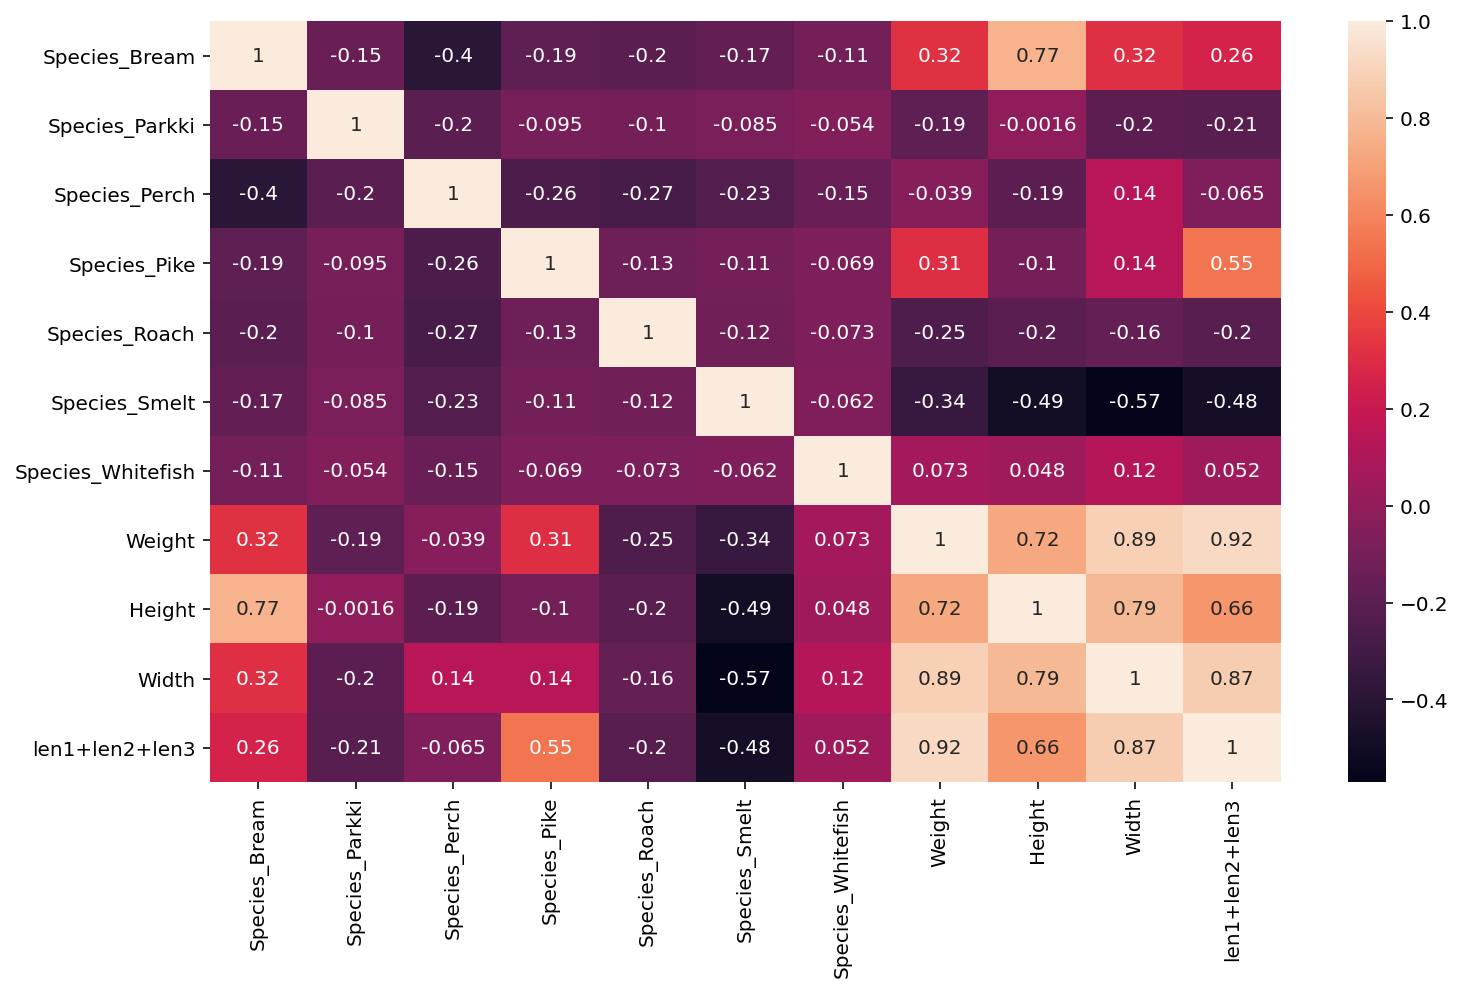

In [58]:
X_new = data.copy().drop(["Species"], axis=1)
X_new = pandas.concat([species, X_new], axis=1)

y_new = data["Weight"] # Fish

#Add length1, length2 and length3 together into a new column and remove the old columns.
X_new["len1+len2+len3"] = X_new.loc[:,['Length1','Length2', 'Length3']].sum(axis=1)
X_new = X_new.drop(["Length1","Length2","Length3"], axis=1)

# Print new correlation matrix and pair plot
corrMatrix = X_new.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#sn.pairplot(X_new)
#plt.show()

X_new = X_new.drop(["Weight"], axis=1)

# Split into training and test data
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.25, random_state=0)  # Unleash the random when all code is finished

# Normalize columns in X, fitting the normalization parameters to the training data only
min_max_scaler = preprocessing.MinMaxScaler()
X_new_train_scaled = min_max_scaler.fit_transform(X_new_train)
X_new_train = pandas.DataFrame(X_new_train_scaled, columns=X_new.columns)

# Use normalization parameters found for the training data to transform the test data.
X_new_test_scaled = min_max_scaler.transform(X_new_test)
X_new_test = pandas.DataFrame(X_new_test_scaled, columns=X_new.columns)


We then attempt to use Ridge regression again.

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.00 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.01 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.02 of 10000.00

Processing alpha 0.03 of 10000.00

Processing alpha 0.04 of 10000.00

Processing alpha 0.04 of 10000.00

Processing alpha 0.05 of 10000.00

Processing alpha 0.07 of 10000.00

Processing alpha 0.08 of 10000.00

Processing alpha 0.10 of 10000.00

Processing alpha 0.12 of 10000.00

Processing alpha 0.15 of 10000.00

Processing alpha 0.19 of 10000.00

Processing alpha 0.23 of 10000.00

Processing alpha 0.28 of 10000.00

Processing alpha 0.35 of 10000.00

Processing alpha 0.43 of 10000.00

Processing alpha 0.53 of 10000.00

Processing alpha 0.66 of 10000.00

Processing alpha 0.81 of 10000.00

Processing alpha 1.00 of 10000.00

Processing alpha 1.23 of 10000.00

Processing alpha 1.52 of 10000.00

Processing alpha 1.87 of 10000.00

Processing alpha 2.31 of 10000.00

Processing alpha 2.85 of 10000.00

Processing alpha 3.51 of 10000.00

Processing alpha 4.33 of 10000.00

Processing alpha 5.34 of 10000.00

Processing alpha 6.58 of 10000.00

Processing alpha 8.11 of 10000.00

Processing alpha 10.00 of 10000.00

Processing alpha 12.33 of 10000.00

Processing alpha 15.20 of 10000.00

Processing alpha 18.74 of 10000.00

Processing alpha 23.10 of 10000.00

Processing alpha 28.48 of 10000.00

Processing alpha 35.11 of 10000.00

Processing alpha 43.29 of 10000.00

Processing alpha 53.37 of 10000.00

Processing alpha 65.79 of 10000.00

Processing alpha 81.11 of 10000.00

Processing alpha 100.00 of 10000.00

Processing alpha 123.28 of 10000.00

Processing alpha 151.99 of 10000.00

Processing alpha 187.38 of 10000.00

Processing alpha 231.01 of 10000.00

Processing alpha 284.80 of 10000.00

Processing alpha 351.12 of 10000.00

Processing alpha 432.88 of 10000.00

Processing alpha 533.67 of 10000.00

Processing alpha 657.93 of 10000.00

Processing alpha 811.13 of 10000.00

Processing alpha 1000.00 of 10000.00

Processing alpha 1232.85 of 10000.00

Processing alpha 1519.91 of 10000.00

Processing alpha 1873.82 of 10000.00

Processing alpha 2310.13 of 10000.00

Processing alpha 2848.04 of 10000.00

Processing alpha 3511.19 of 10000.00

Processing alpha 4328.76 of 10000.00

Processing alpha 5336.70 of 10000.00

Processing alpha 6579.33 of 10000.00

Processing alpha 8111.31 of 10000.00

Processing alpha 10000.00 of 10000.00

Best alpha is  0.05336699231206313
Score is 0.914 +/- 0.041


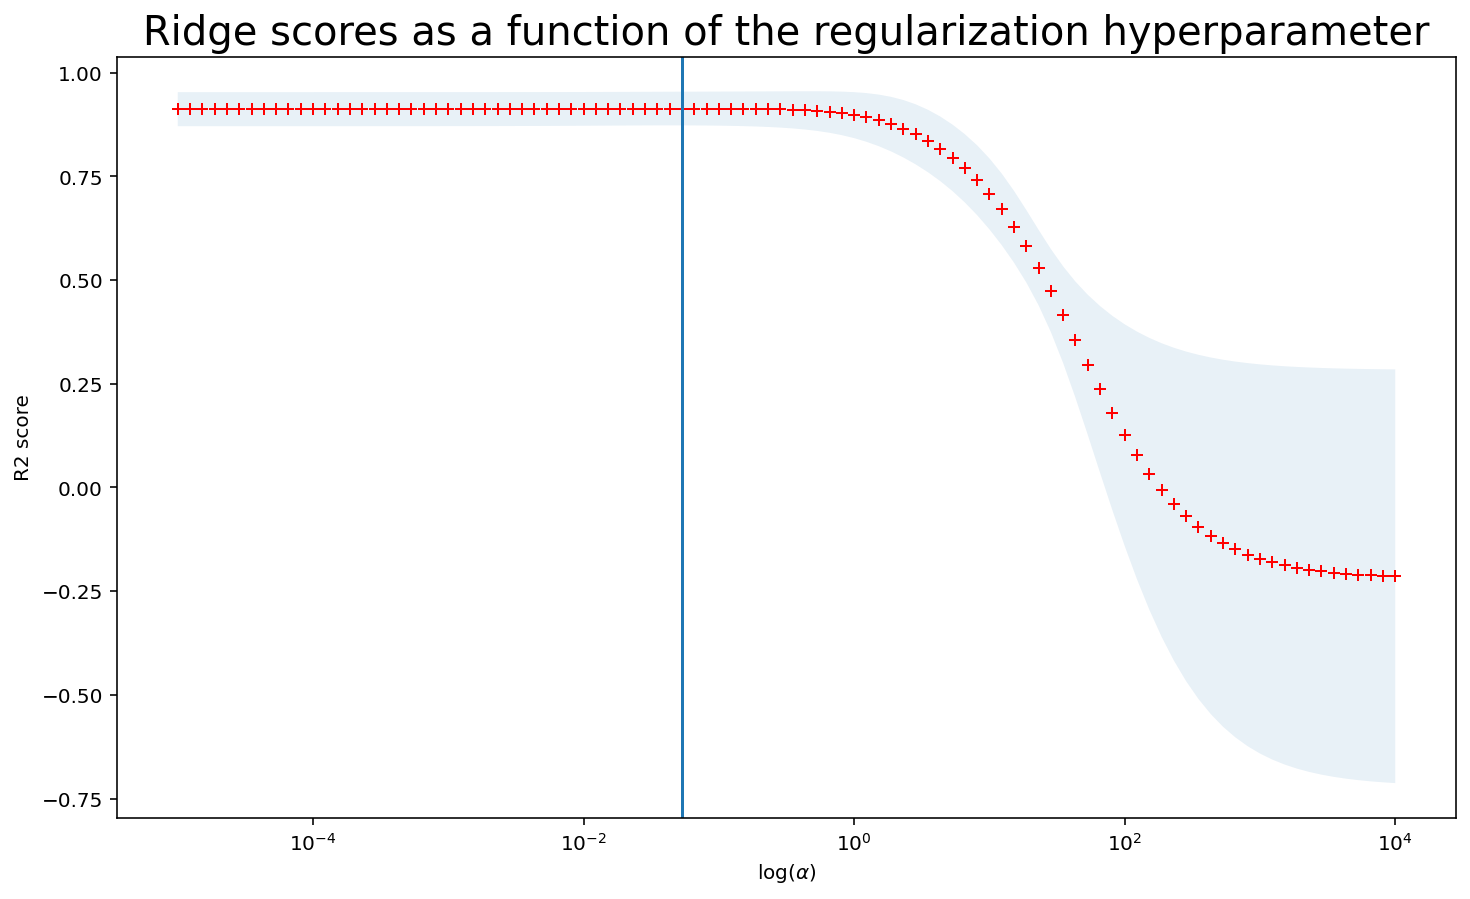

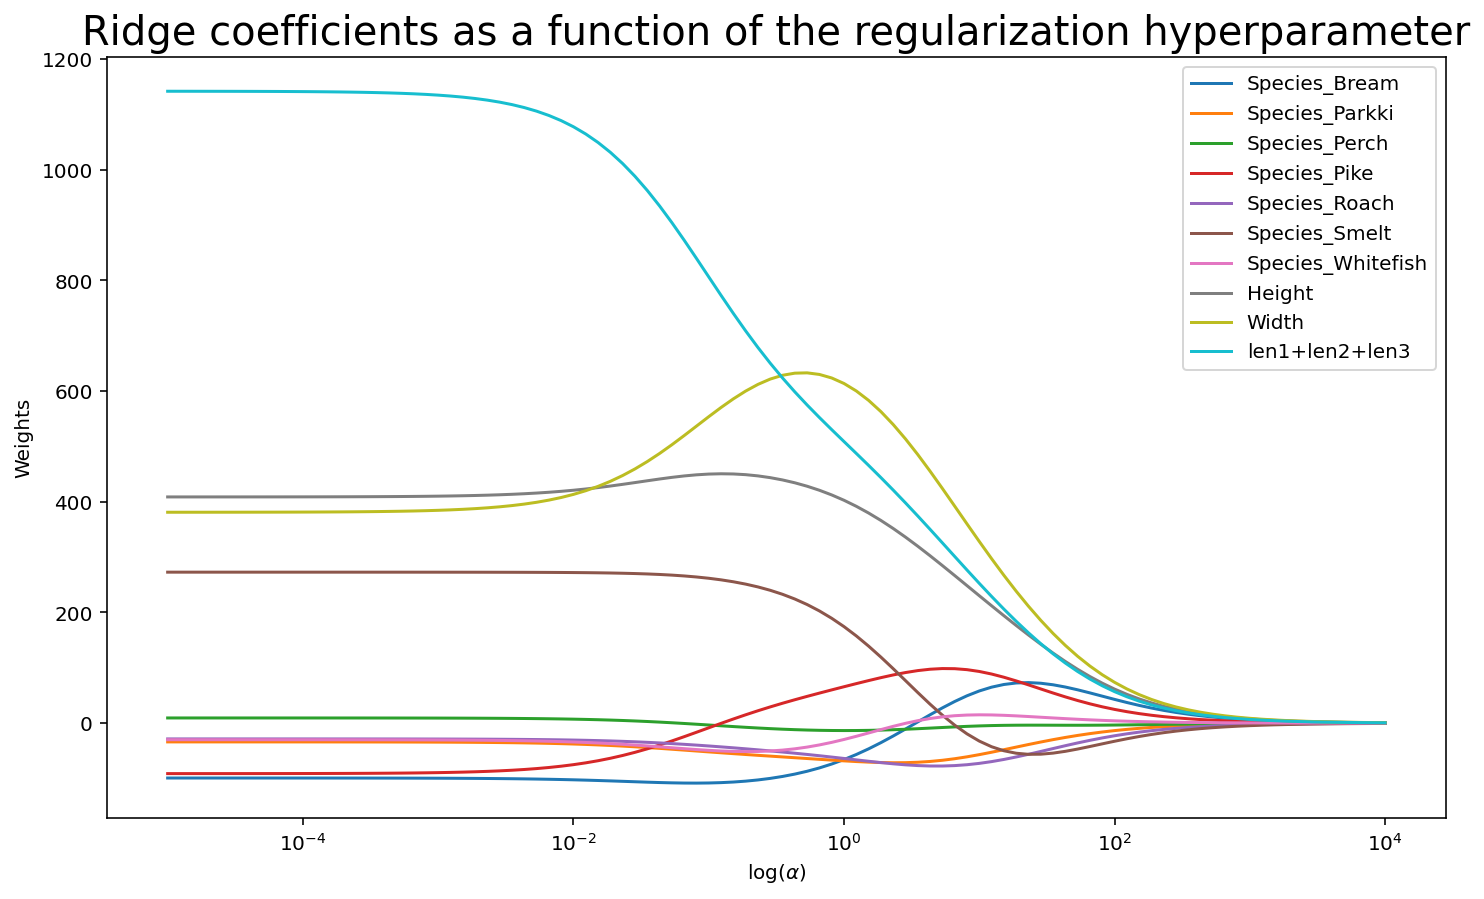

In [59]:
#Choose a range of interest for the penalty hyperparameter, where all coefficients are zero in one end and all coefficients are not zero in the other end.
alphas = np.logspace(-5, 4, 100)
method = lm.Ridge

# Get mean/std and coeffs for Ridge regression method
ridge_means, ridge_stds, coeffs = reg_select(method, X_new_train, y_new_train, alphas)

# Plot them
plot_regularizer(alphas, ridge_means, ridge_stds, coeffs, list(X_new_train.columns), method="Ridge")

alpha_best = alphas[np.argmax(ridge_means)]
best_mean = ridge_means[np.argmax(ridge_means)]
best_std = ridge_stds[np.argmax(ridge_means)]
print("Best alpha is ", alpha_best)
print("Score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

# Fit model with the optimal regularizer
Ridge_model_new = lm.Ridge(alpha=alpha_best).fit(X_new_train, y_new_train)

When comparing the previous coefficient plot for Ridge with the new coefficient plot above, we can see that the new coefficient (len1+len2+len3) is more on the same scale as the other coefficients. This model still gets approximately the same R2 score as the previous Ridge model. 

# Results

In this section we test the best performing method from the cross-validation on the test data, and report and discuss the results. 

### Table showing the best cross-validation results of the models used in this paper

| Model | Mean CV R2-score | Standard deviation CV R2 score |
| --- | --- | --- |
| OLS | 0.908 | 0.048 |
| **Ridge** | **0.915** | **0.037** |
| Lasso | 0.914 | 0.039 |
| Ridge with correlated columns combined | 0.914 | 0.041 |
| Group lasso | 0.915 | 0.040 |

As can been seen from the table above, the model that got the best cross-validation results from the experiments done in this report is Ridge regression. Therefore, we now test this model on the test data. 

In [52]:
# Train a new model with best method and its best regularizer parameter
model = lm.Ridge(alpha=alpha_best).fit(X_train,y_train)

print(model.score(X_test, y_test))

# Predict some fish weights
pred = model.predict(X=X_test)
np.random.seed(1)
for i in np.random.randint(0,len(X_test), size=10):
    print("Fish #", i+1, "weight:", y_test.iloc[i], "\t model prediction:", pred[i])

0.8808054979975052
Fish # 38 weight: 170.0 	 model prediction: 167.14164824111293
Fish # 13 weight: 720.0 	 model prediction: 720.6629800899432
Fish # 9 weight: 556.0 	 model prediction: 668.043622870307
Fish # 10 weight: 145.0 	 model prediction: 173.58832441841474
Fish # 12 weight: 1600.0 	 model prediction: 1063.4523702836339
Fish # 6 weight: 1100.0 	 model prediction: 903.6417195044226
Fish # 16 weight: 188.0 	 model prediction: 261.1269001070813
Fish # 1 weight: 390.0 	 model prediction: 456.1132298174329
Fish # 17 weight: 300.0 	 model prediction: 386.47331011162015
Fish # 2 weight: 160.0 	 model prediction: 175.97535477851767


The R2-score on the test set is worse than the mean from the cross-validation. However, this is not unreasonable, since the test set contains 25% of the total data, which is totally unseen. The score on the test set is also within one standard deviation from the mean score of the cross-validation performance.

When the weights of ten randomly chosen fish from the test set are predicted, some of the weights are predicted quite accurately, and some are not. 




## Comparing model coefficients

To further compare the different models, we will now plot the coefficients of the different models used in this report.


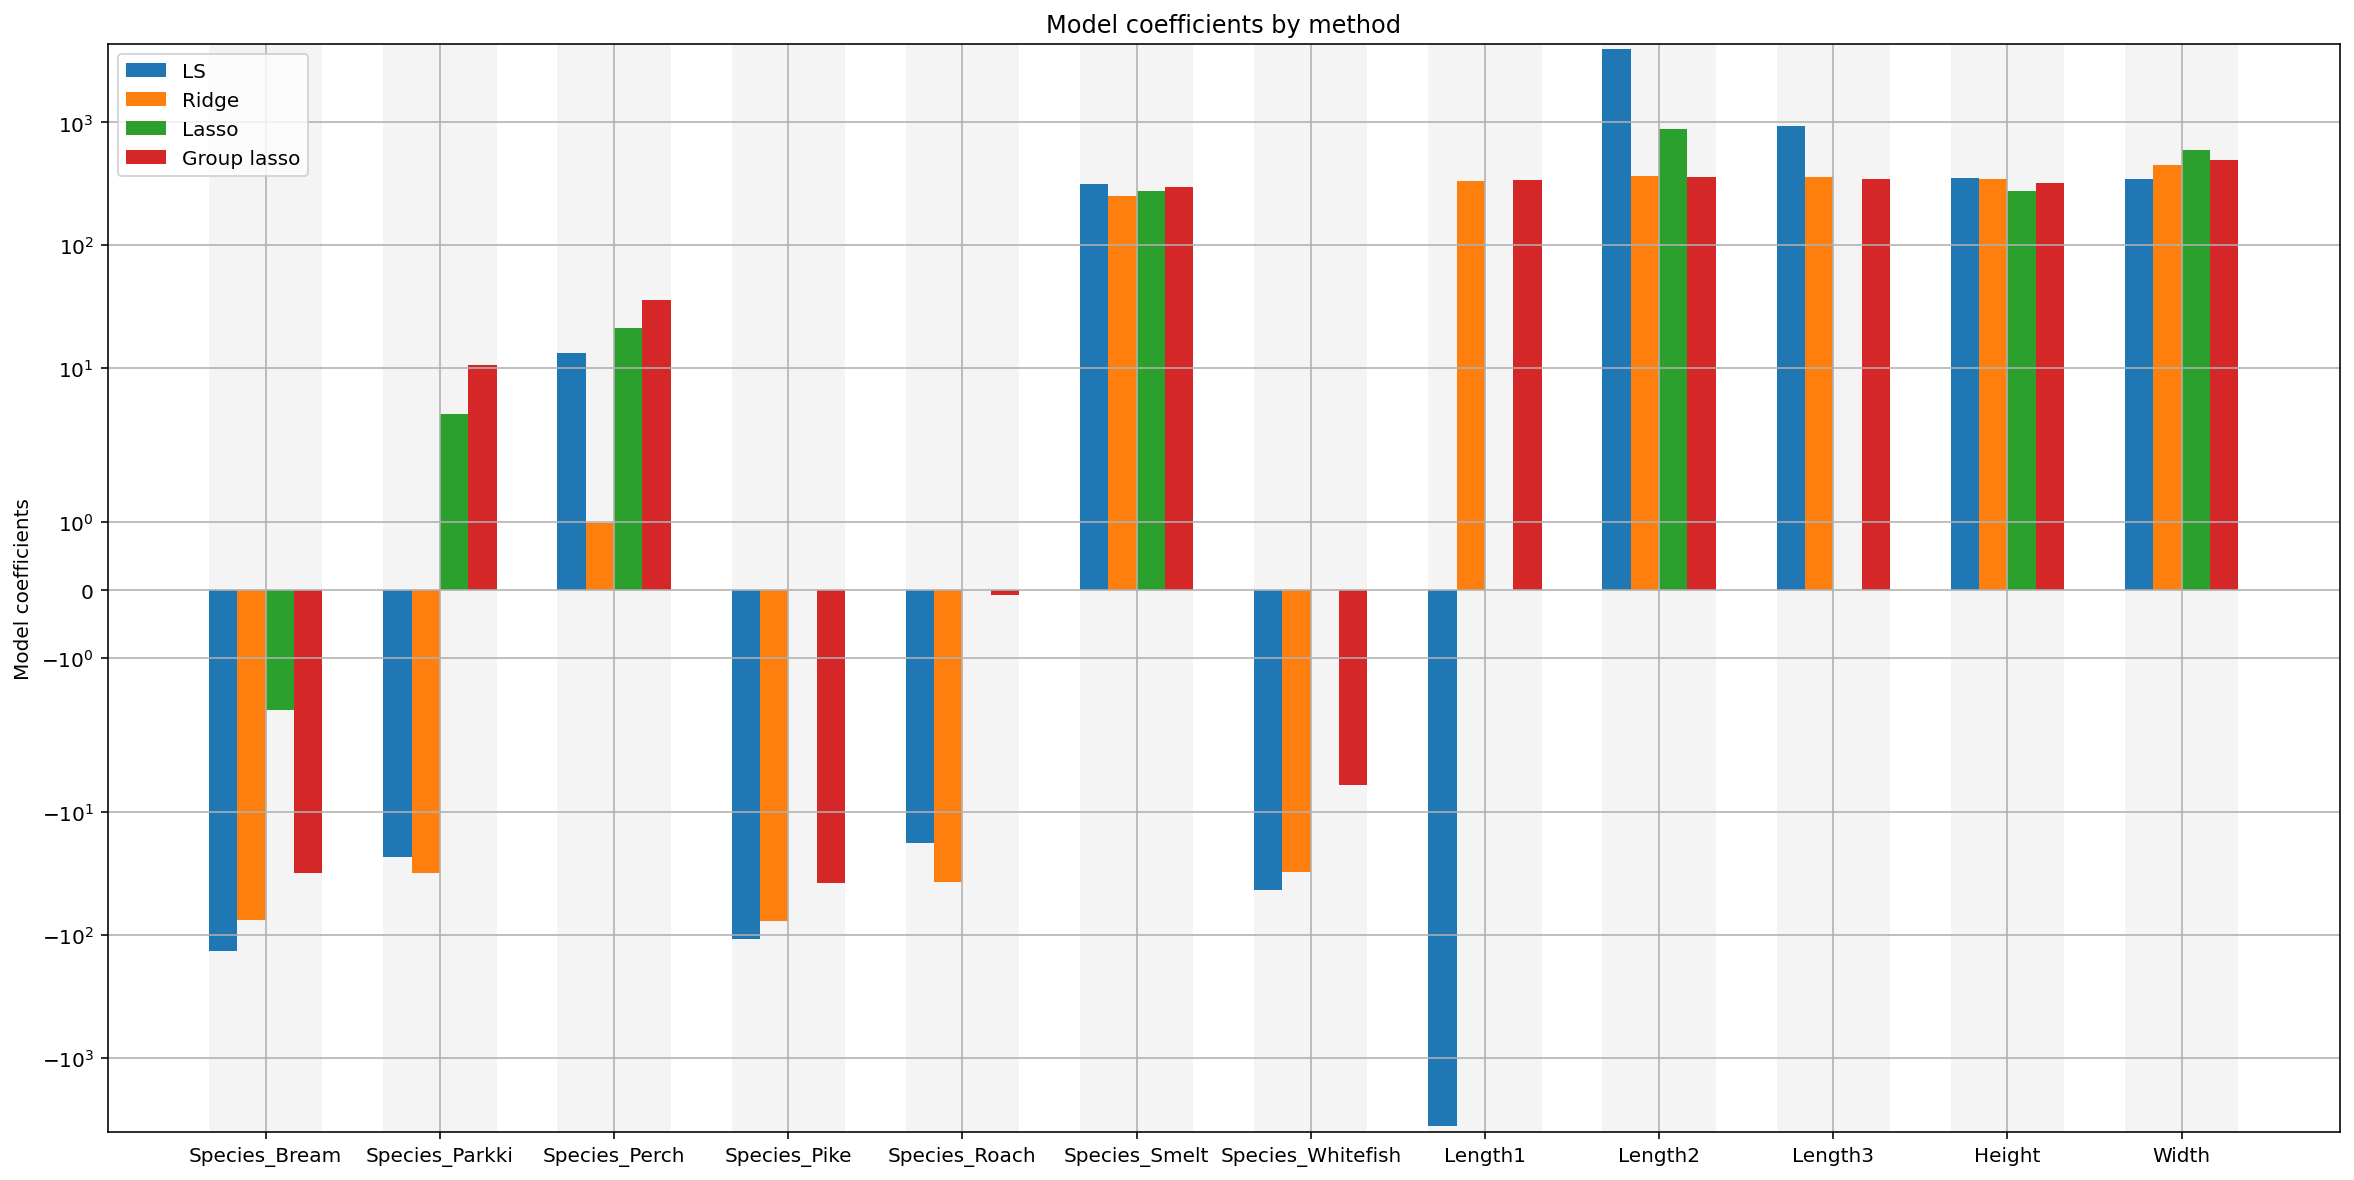

In [71]:
# Relate coefficients to covariates
labels = list(X_train.columns)

x = np.arange(12)  # the label locations
width = 0.65  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))

for i in x: # Gray background
    ax.axvspan(i-width/2, i+width/2, facecolor='0.2', alpha=0.05)

rects1 = ax.bar(x - 3*width/8, LS_model.coef_, width/4, label='LS')
rects2 = ax.bar(x - width/8, Ridge_model.coef_, width/4, label='Ridge')
rects3 = ax.bar(x+width/8, Lasso_model.coef_, width/4, label='Lasso')
rects4 = ax.bar(x + 3*width/8, np.squeeze(gl_model.coef_), width/4, label='Group lasso')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model coefficients')
ax.set_title('Model coefficients by method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(bottom=-1000, top=1000)
ax.legend()



ax.set_yscale('symlog')
#fig.tight_layout()
plt.grid()
plt.show()


# References

[1] Hastie, T., Hastie, T., Tibshirani, R., & Friedman, J. H. (2001). The elements of statistical learning: Data mining, inference, and prediction. New York: Springer.

[2] Dataset: https://www.kaggle.com/aungpyaeap/fish-market

[3] Moe, Y. M. (2019), Group-lasso docs https://group-lasso.readthedocs.io/